# **Real / Fake Job Posting Prediction**

## Imports

In [5]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [6]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [7]:
import seaborn as sb
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import *
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
import time

## Part A: Data Cleaning

In [8]:
fjp = pd.read_csv('fake_job_postings.csv')
fjp.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [9]:
fjp.shape

(17880, 18)

#### 1. Removing all columns with more than 50% missing values: This will allow us to work faster (and our data set is large enough that it will still be meaningful without them.  
#### 2. Remove the first line: it contains extraneous text instead of the column titles. This text prevents the data set from being parsed properly by the pandas library.
#### 3.Remove the ‘benefit’ column: it contains a long text that we won’t need.

In [10]:
fjp.isna().sum()/len(fjp)      

job_id                 0.000000
title                  0.000000
location               0.019351
department             0.645805
salary_range           0.839597
company_profile        0.185011
description            0.000056
requirements           0.150783
benefits               0.403356
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
employment_type        0.194128
required_experience    0.394295
required_education     0.453300
industry               0.274217
function               0.361018
fraudulent             0.000000
dtype: float64

### Make a copy of dataset !!

In [11]:
fjp2= fjp.copy()

In [12]:
fjp2.drop(['job_id','salary_range',  'department', 'benefits'], axis = 1, inplace = True)  ##drop variables

In [13]:
fjp2.head()

,title,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [14]:
fjp2 = fjp2.sort_values('title').reset_index(drop = True)   ##sort and Resetting index according Titile. If you set drop = True , the current index will be deleted entirely and the numeric index will replace it.

In [15]:
fjp2.isna().sum()    ##count the null values

title                     0
location                346
company_profile        3308
description               1
requirements           2696
telecommuting             0
has_company_logo          0
has_questions             0
employment_type        3471
required_experience    7050
required_education     8105
industry               4903
function               6455
fraudulent                0
dtype: int64

In [16]:
fjp2['employment_type'] = fjp2['employment_type'].bfill(axis=0)
fjp2['required_experience'] = fjp2['required_experience'].bfill(axis=0)
fjp2['required_education'] = fjp2['required_education'].bfill(axis = 0)
fjp2['industry'] = fjp2['industry'].bfill(axis=0)
fjp2['function'] = fjp2['function'].bfill(axis=0)
## use bfill(axis=0) to fill the missing values with 0 in the dataset. 

In [17]:
fjp2 = fjp2[fjp2['description'].notna()]  ## Use The notna() method returns a DataFrame object where all the values are replaced with a Boolean value True for NOT NA (not-a -number) values, and otherwise False.

In [18]:
fjp2.isna().sum()

title                     0
location                346
company_profile        3307
description               0
requirements           2695
telecommuting             0
has_company_logo          0
has_questions             0
employment_type           2
required_experience       2
required_education        2
industry                  2
function                  2
fraudulent                0
dtype: int64

In [19]:
fjp2 = fjp2.dropna(axis = 0, how = 'any')  ## Drop the rows where any of the elements are nan

In [20]:
fjp2.shape

(12500, 14)

In [21]:
fjp2 = fjp2.drop_duplicates(keep = 'first') ## removes duplicate rows from the DataFrame

In [22]:
fjp2.shape

(12263, 14)

In [23]:
fjp2.head()

,title,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
2,Piping Material Engineer,"US, TX, Houston",Aker Solutions is a global provider of product...,Corporate overviewAker Solutions is a global p...,Qualifications &amp; personal attributes• High...,0,1,0,Full-time,Mid-Senior level,Master's Degree,Oil & Energy,Engineering,1
3,"Discipline Manager Civil, Structural, Marine...","US, TX, Houston",Aker Solutions is a global provider of product...,Corporate overviewAker Solutions is a global p...,"EXPERIENCE: - Good awareness of construction,t...",0,1,0,Full-time,Entry level,Professional,Oil & Energy,Engineering,1
4,FEA Senior engineer,"US, TX, Houston",Aker Solutions is a global provider of product...,Corporate overviewAker Solutions is a global p...,Qualifications &amp; personal attributes• MSc ...,0,1,0,Full-time,Entry level,Master's Degree,Oil & Energy,Engineering,1
9,AUTOCAD OPERATOR,"PH, 07, Cebu",Zylun’s mission is to help small and medium si...,Responsibilities:Using a project database syst...,Requirements:1-3 years’ experience of CAD base...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Staffing and Recruiting,Engineering,0
13,Accounting Clerk,"US, TX, AUSTIN",As the industry’s largest supply contracting c...,"Job DescriptionVerify, obtain approvals and pa...",High School diploma requiredProficient in usin...,0,1,1,Full-time,Associate,High School or equivalent,Accounting,Customer Service,1


In [24]:
fjp2['description'] = fjp2['description'] + ' ' + fjp2['requirements'] + ' ' + fjp2['company_profile']
fjp2.drop(['company_profile', 'requirements'], axis = 1, inplace = True) 
## combine Description , Requirements and Company_profile into one column with space between and delete the original columns

In [25]:
fjp2.head(5)

,title,location,description,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
2,Piping Material Engineer,"US, TX, Houston",Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Mid-Senior level,Master's Degree,Oil & Energy,Engineering,1
3,"Discipline Manager Civil, Structural, Marine...","US, TX, Houston",Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Entry level,Professional,Oil & Energy,Engineering,1
4,FEA Senior engineer,"US, TX, Houston",Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Entry level,Master's Degree,Oil & Energy,Engineering,1
9,AUTOCAD OPERATOR,"PH, 07, Cebu",Responsibilities:Using a project database syst...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Staffing and Recruiting,Engineering,0
13,Accounting Clerk,"US, TX, AUSTIN","Job DescriptionVerify, obtain approvals and pa...",0,1,1,Full-time,Associate,High School or equivalent,Accounting,Customer Service,1


In [26]:
fjp2['country'] = fjp2['location'].str.split(',', expand=True)[0]
fjp2['city'] = fjp2['location'].str.split(',', expand = True)[2]
## Add two colums Country and City ,data from Location

In [27]:
fjp2.head()

,title,location,description,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,city
2,Piping Material Engineer,"US, TX, Houston",Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Mid-Senior level,Master's Degree,Oil & Energy,Engineering,1,US,Houston
3,"Discipline Manager Civil, Structural, Marine...","US, TX, Houston",Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Entry level,Professional,Oil & Energy,Engineering,1,US,Houston
4,FEA Senior engineer,"US, TX, Houston",Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Entry level,Master's Degree,Oil & Energy,Engineering,1,US,Houston
9,AUTOCAD OPERATOR,"PH, 07, Cebu",Responsibilities:Using a project database syst...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Staffing and Recruiting,Engineering,0,PH,Cebu
13,Accounting Clerk,"US, TX, AUSTIN","Job DescriptionVerify, obtain approvals and pa...",0,1,1,Full-time,Associate,High School or equivalent,Accounting,Customer Service,1,US,AUSTIN


In [28]:
fjp2.loc[fjp2['city'] == ' ', 'city'] = np.nan
## locate the missing value

In [29]:
fjp2.isna().sum()

title                    0
location                 0
description              0
telecommuting            0
has_company_logo         0
has_questions            0
employment_type          0
required_experience      0
required_education       0
industry                 0
function                 0
fraudulent               0
country                  0
city                   991
dtype: int64

In [30]:
fjp2.shape

(12263, 14)

In [31]:
fjp2.dropna(inplace = True)
## Keep the DataFrame with valid entries in the same variable.

In [32]:
import pycountry
list_alpha_2 = [i.alpha_2 for i in list(pycountry.countries)]
def country(df):
    if df['country'] in list_alpha_2:
        return pycountry.countries.get(alpha_2 = df['country']).name
fjp2['country_name'] = fjp2.apply(country, axis = 1)
## Use pycountry packages change the country name in data base.

In [33]:
fjp2.drop(['location','country'], axis = 1, inplace = True)

In [34]:
fjp2.head()

,title,description,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,city,country_name
2,Piping Material Engineer,Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Mid-Senior level,Master's Degree,Oil & Energy,Engineering,1,Houston,United States
3,"Discipline Manager Civil, Structural, Marine...",Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Entry level,Professional,Oil & Energy,Engineering,1,Houston,United States
4,FEA Senior engineer,Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Entry level,Master's Degree,Oil & Energy,Engineering,1,Houston,United States
9,AUTOCAD OPERATOR,Responsibilities:Using a project database syst...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Staffing and Recruiting,Engineering,0,Cebu,Philippines
13,Accounting Clerk,"Job DescriptionVerify, obtain approvals and pa...",0,1,1,Full-time,Associate,High School or equivalent,Accounting,Customer Service,1,AUSTIN,United States


## Part B: Exploratory analysis 

### Distribution of target variable

fraudulent
0    11023
1      249
Name: count, dtype: int64


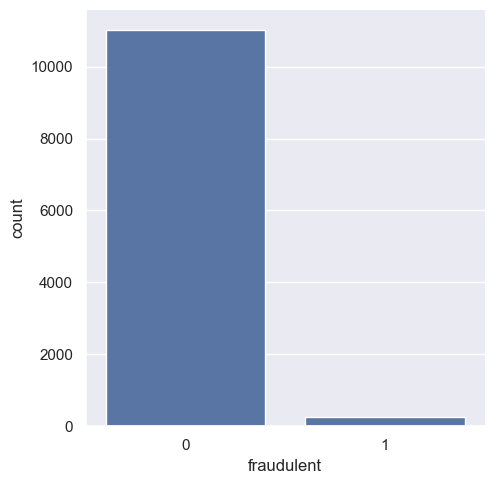

In [35]:
print(fjp2["fraudulent"].value_counts())
sb.catplot(x = "fraudulent", data = fjp2, kind = "count")

### Distribution of other variables in the dataset

required_education
Bachelor's Degree                    6192
High School or equivalent            2196
Unspecified                          1573
Master's Degree                       488
Associate Degree                      318
Certification                         201
Some College Coursework Completed     113
Professional                           86
Vocational                             60
Doctorate                              26
Some High School Coursework            10
Vocational - HS Diploma                 6
Vocational - Degree                     3
Name: count, dtype: int64


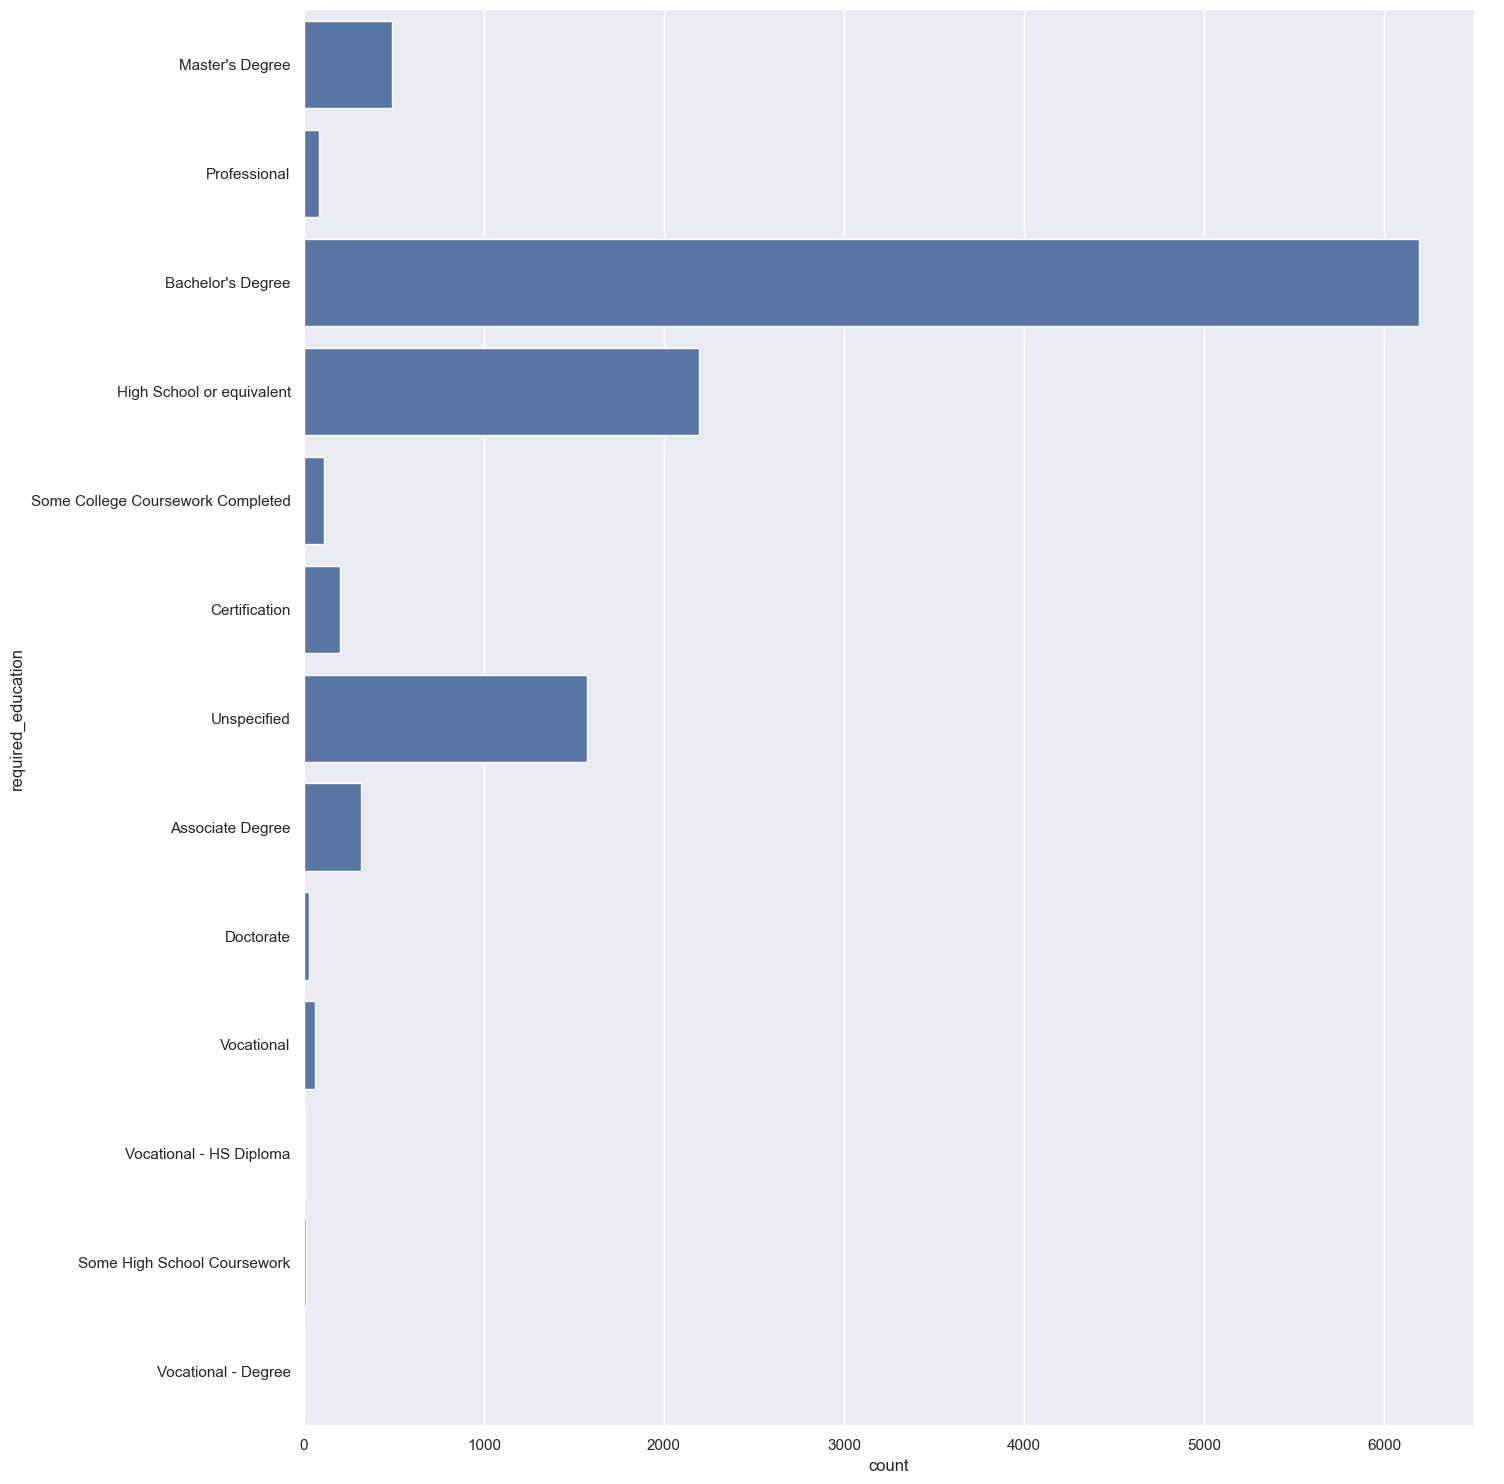

In [36]:
print(fjp2["required_education"].value_counts())
sb.catplot(y = "required_education", data = fjp2, kind = "count", height = 15)

employment_type
Full-time    9145
Contract     1216
Part-time     565
Temporary     184
Other         162
Name: count, dtype: int64


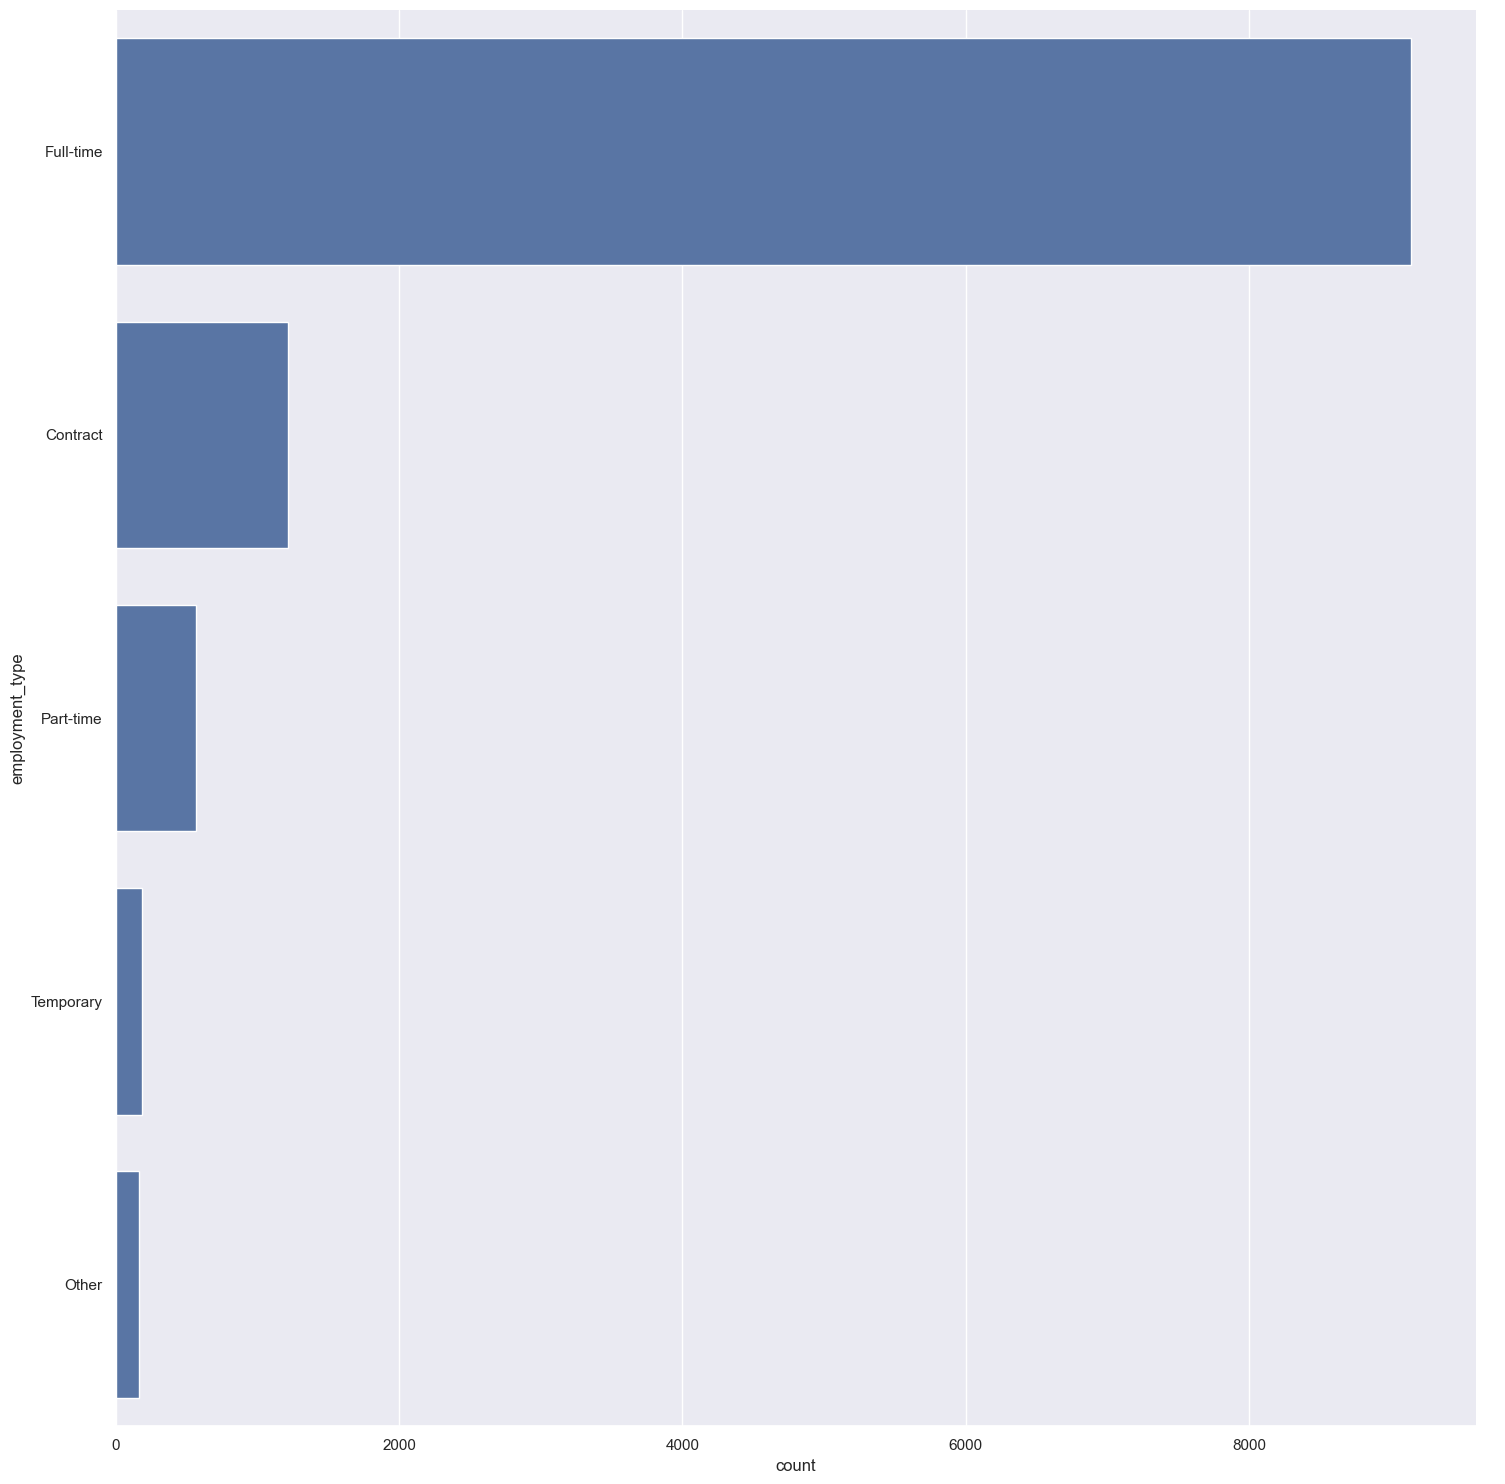

In [37]:
print(fjp2["employment_type"].value_counts())
sb.catplot(y = "employment_type", data = fjp2, kind = "count", height = 15)

required_experience
Mid-Senior level    3916
Entry level         3094
Associate           2452
Not Applicable      1023
Director             356
Internship           318
Executive            113
Name: count, dtype: int64


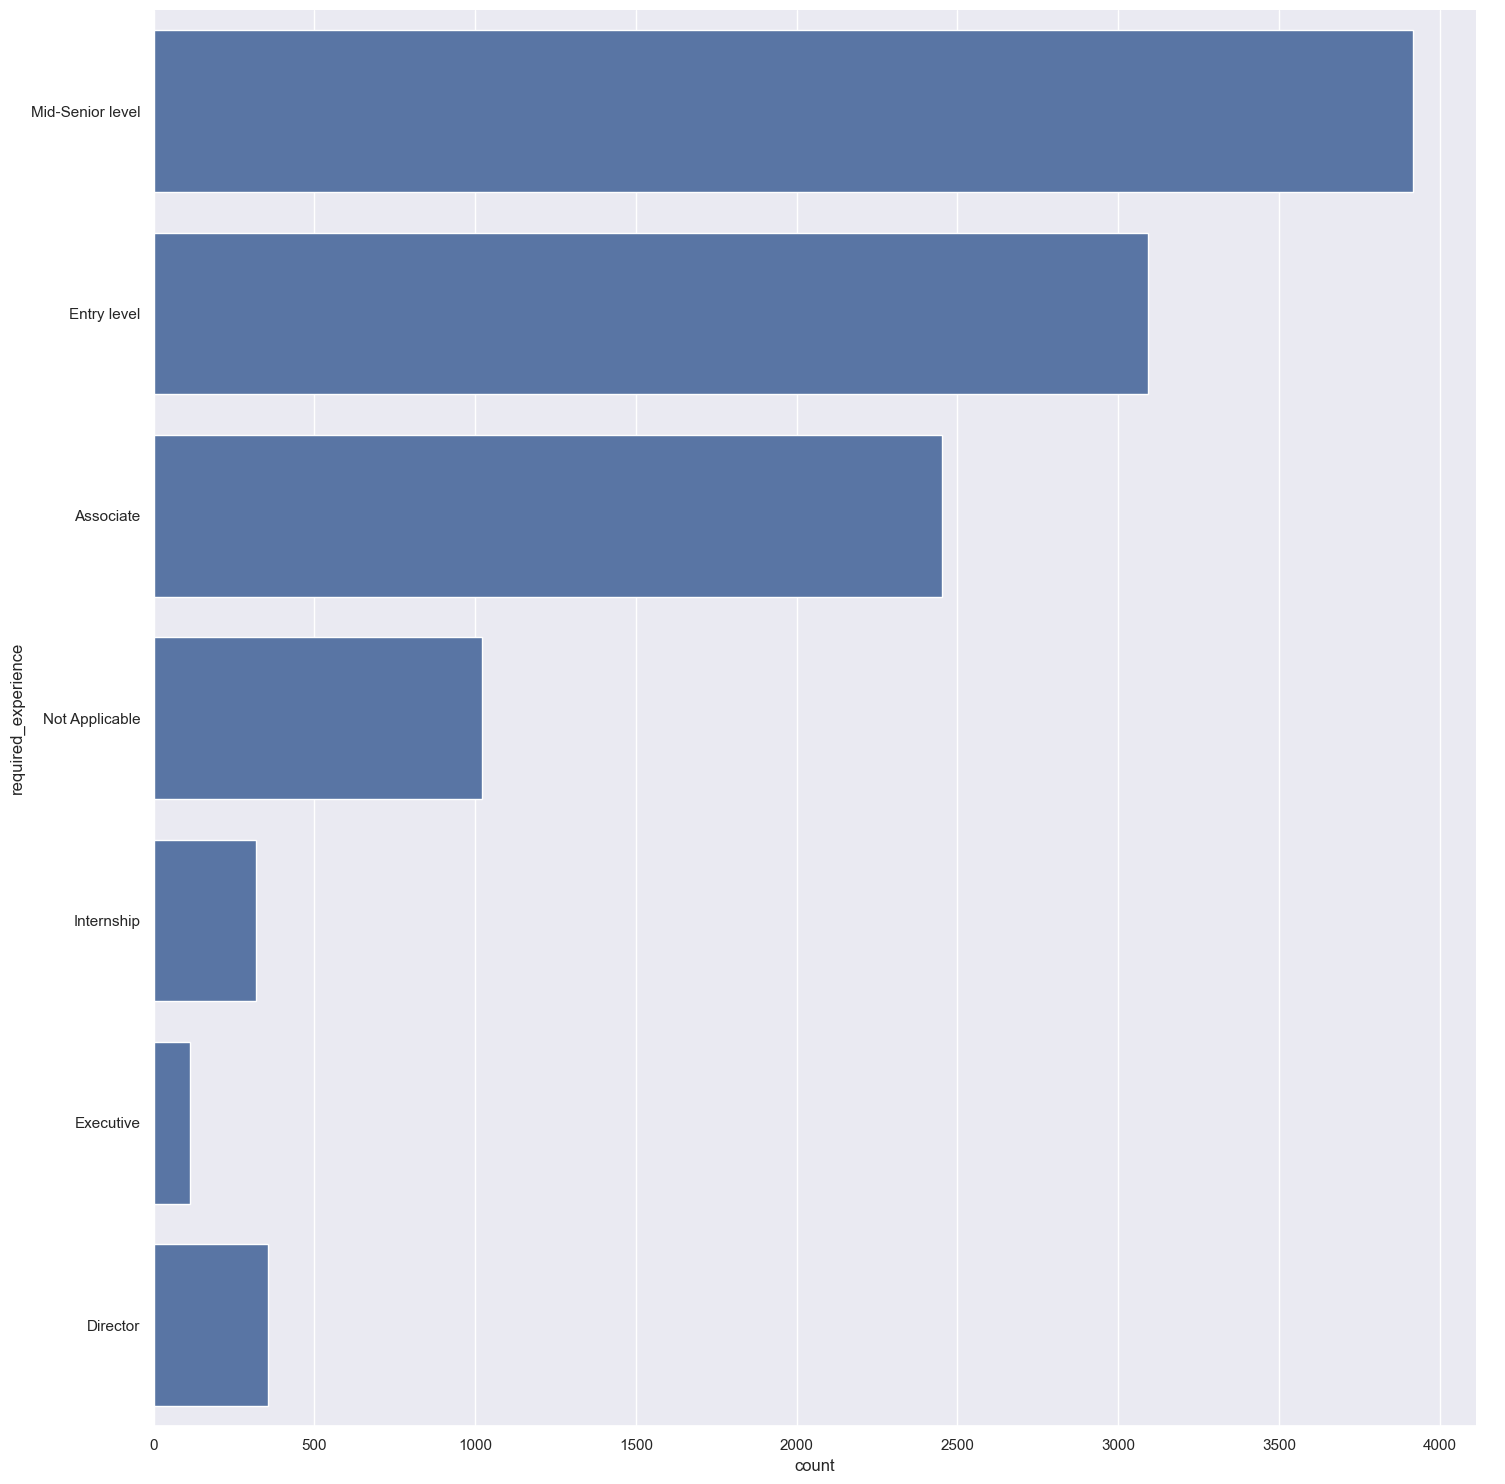

In [38]:
print(fjp2["required_experience"].value_counts())
sb.catplot(y = "required_experience", data = fjp2, kind = "count", height = 15)

### Distribution of job functions and industries

function
Information Technology    1571
Engineering               1331
Sales                     1269
Customer Service          1206
Education                  839
Marketing                  752
Administrative             542
Design                     348
Other                      330
Management                 316
Health Care Provider       309
Business Development       198
Human Resources            198
Project Management         194
Accounting/Auditing        170
Finance                    157
Art/Creative               149
Consulting                 142
Writing/Editing            138
Advertising                129
Product Management         123
Quality Assurance          105
Business Analyst            91
Data Analyst                85
Production                  83
Public Relations            78
Manufacturing               59
General Business            58
Research                    48
Strategy/Planning           45
Training                    41
Legal                       41

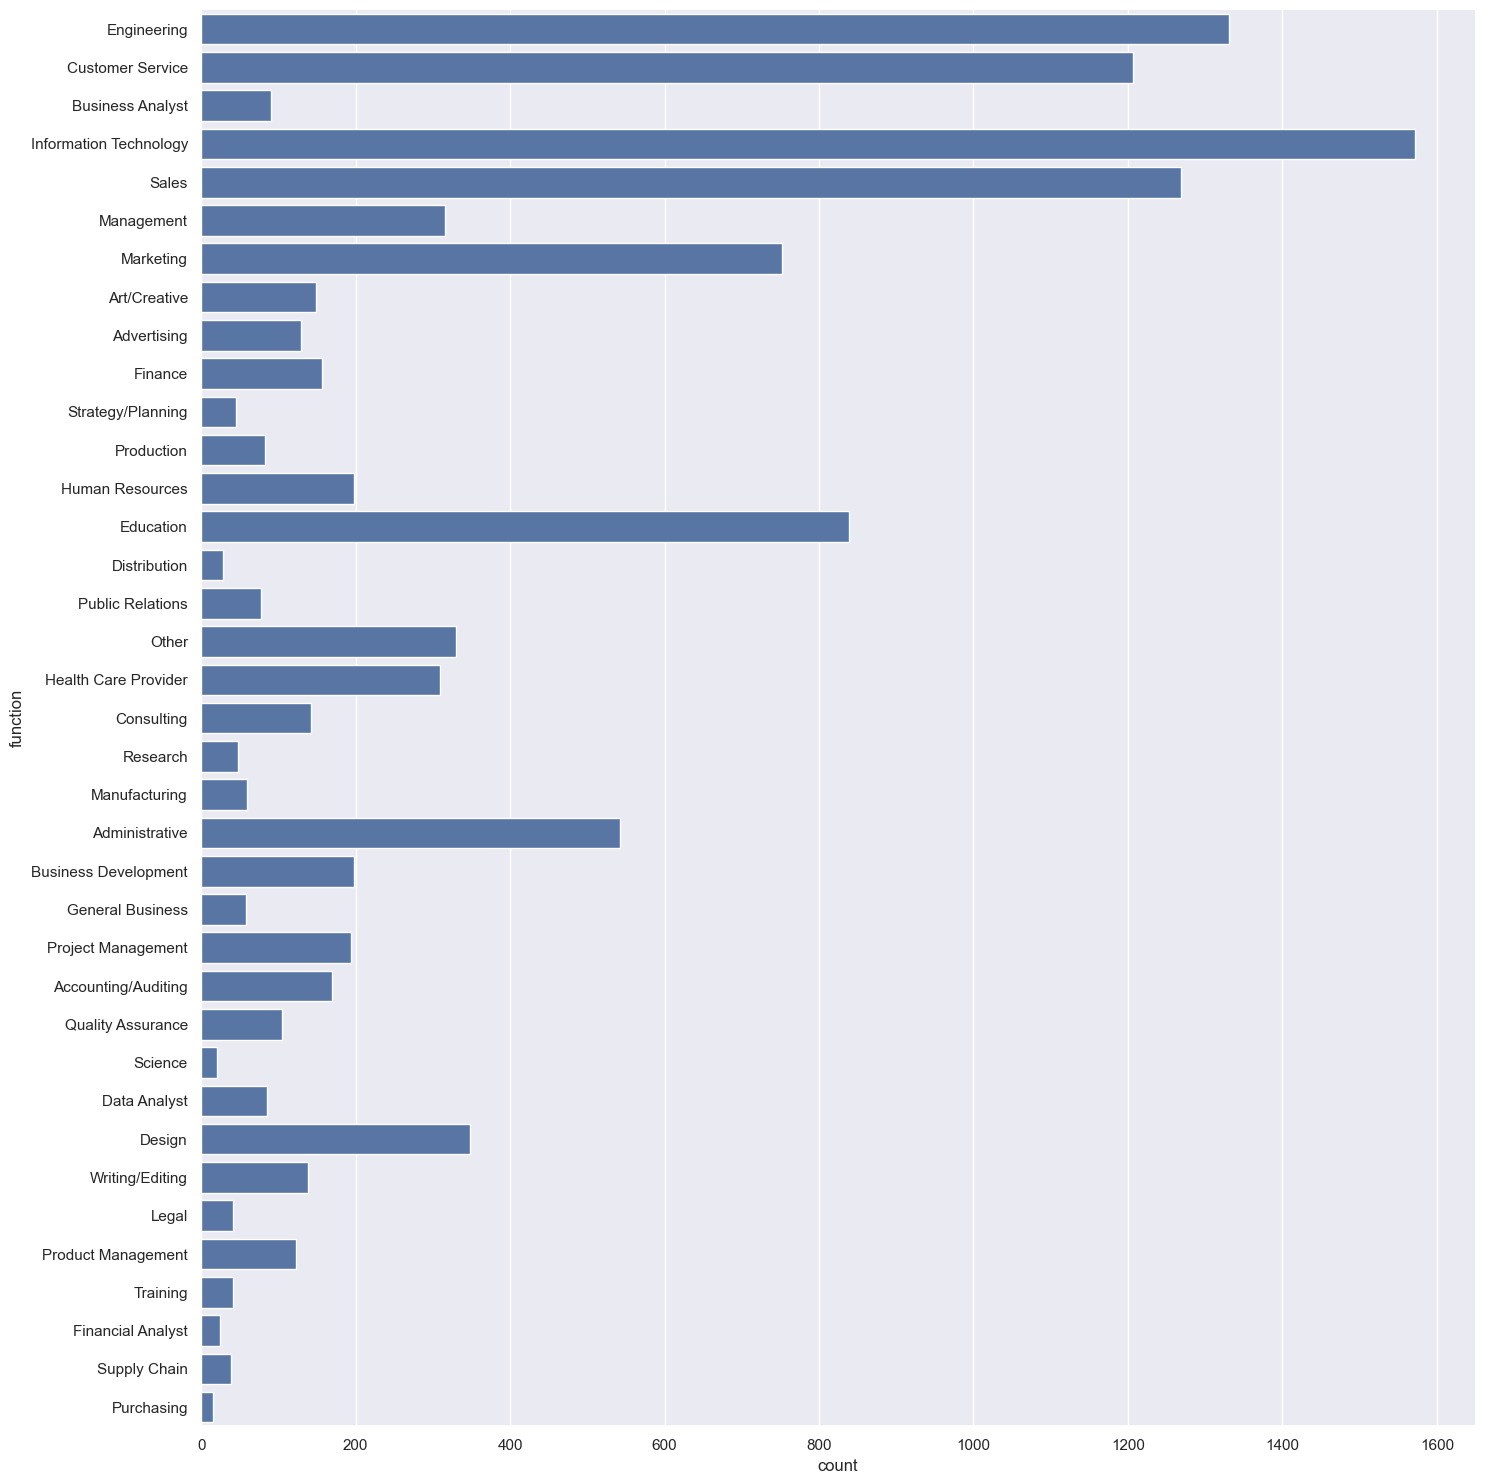

In [39]:
print(fjp2["function"].value_counts())
sb.catplot(y = "function", data = fjp2, kind = "count", height = 15)

industry
Information Technology and Services    1435
Computer Software                      1230
Internet                               1027
Education Management                    792
Marketing and Advertising               702
                                       ... 
Museums and Institutions                  1
Wine and Spirits                          1
Package/Freight Delivery                  1
Public Policy                             1
Alternative Dispute Resolution            1
Name: count, Length: 128, dtype: int64


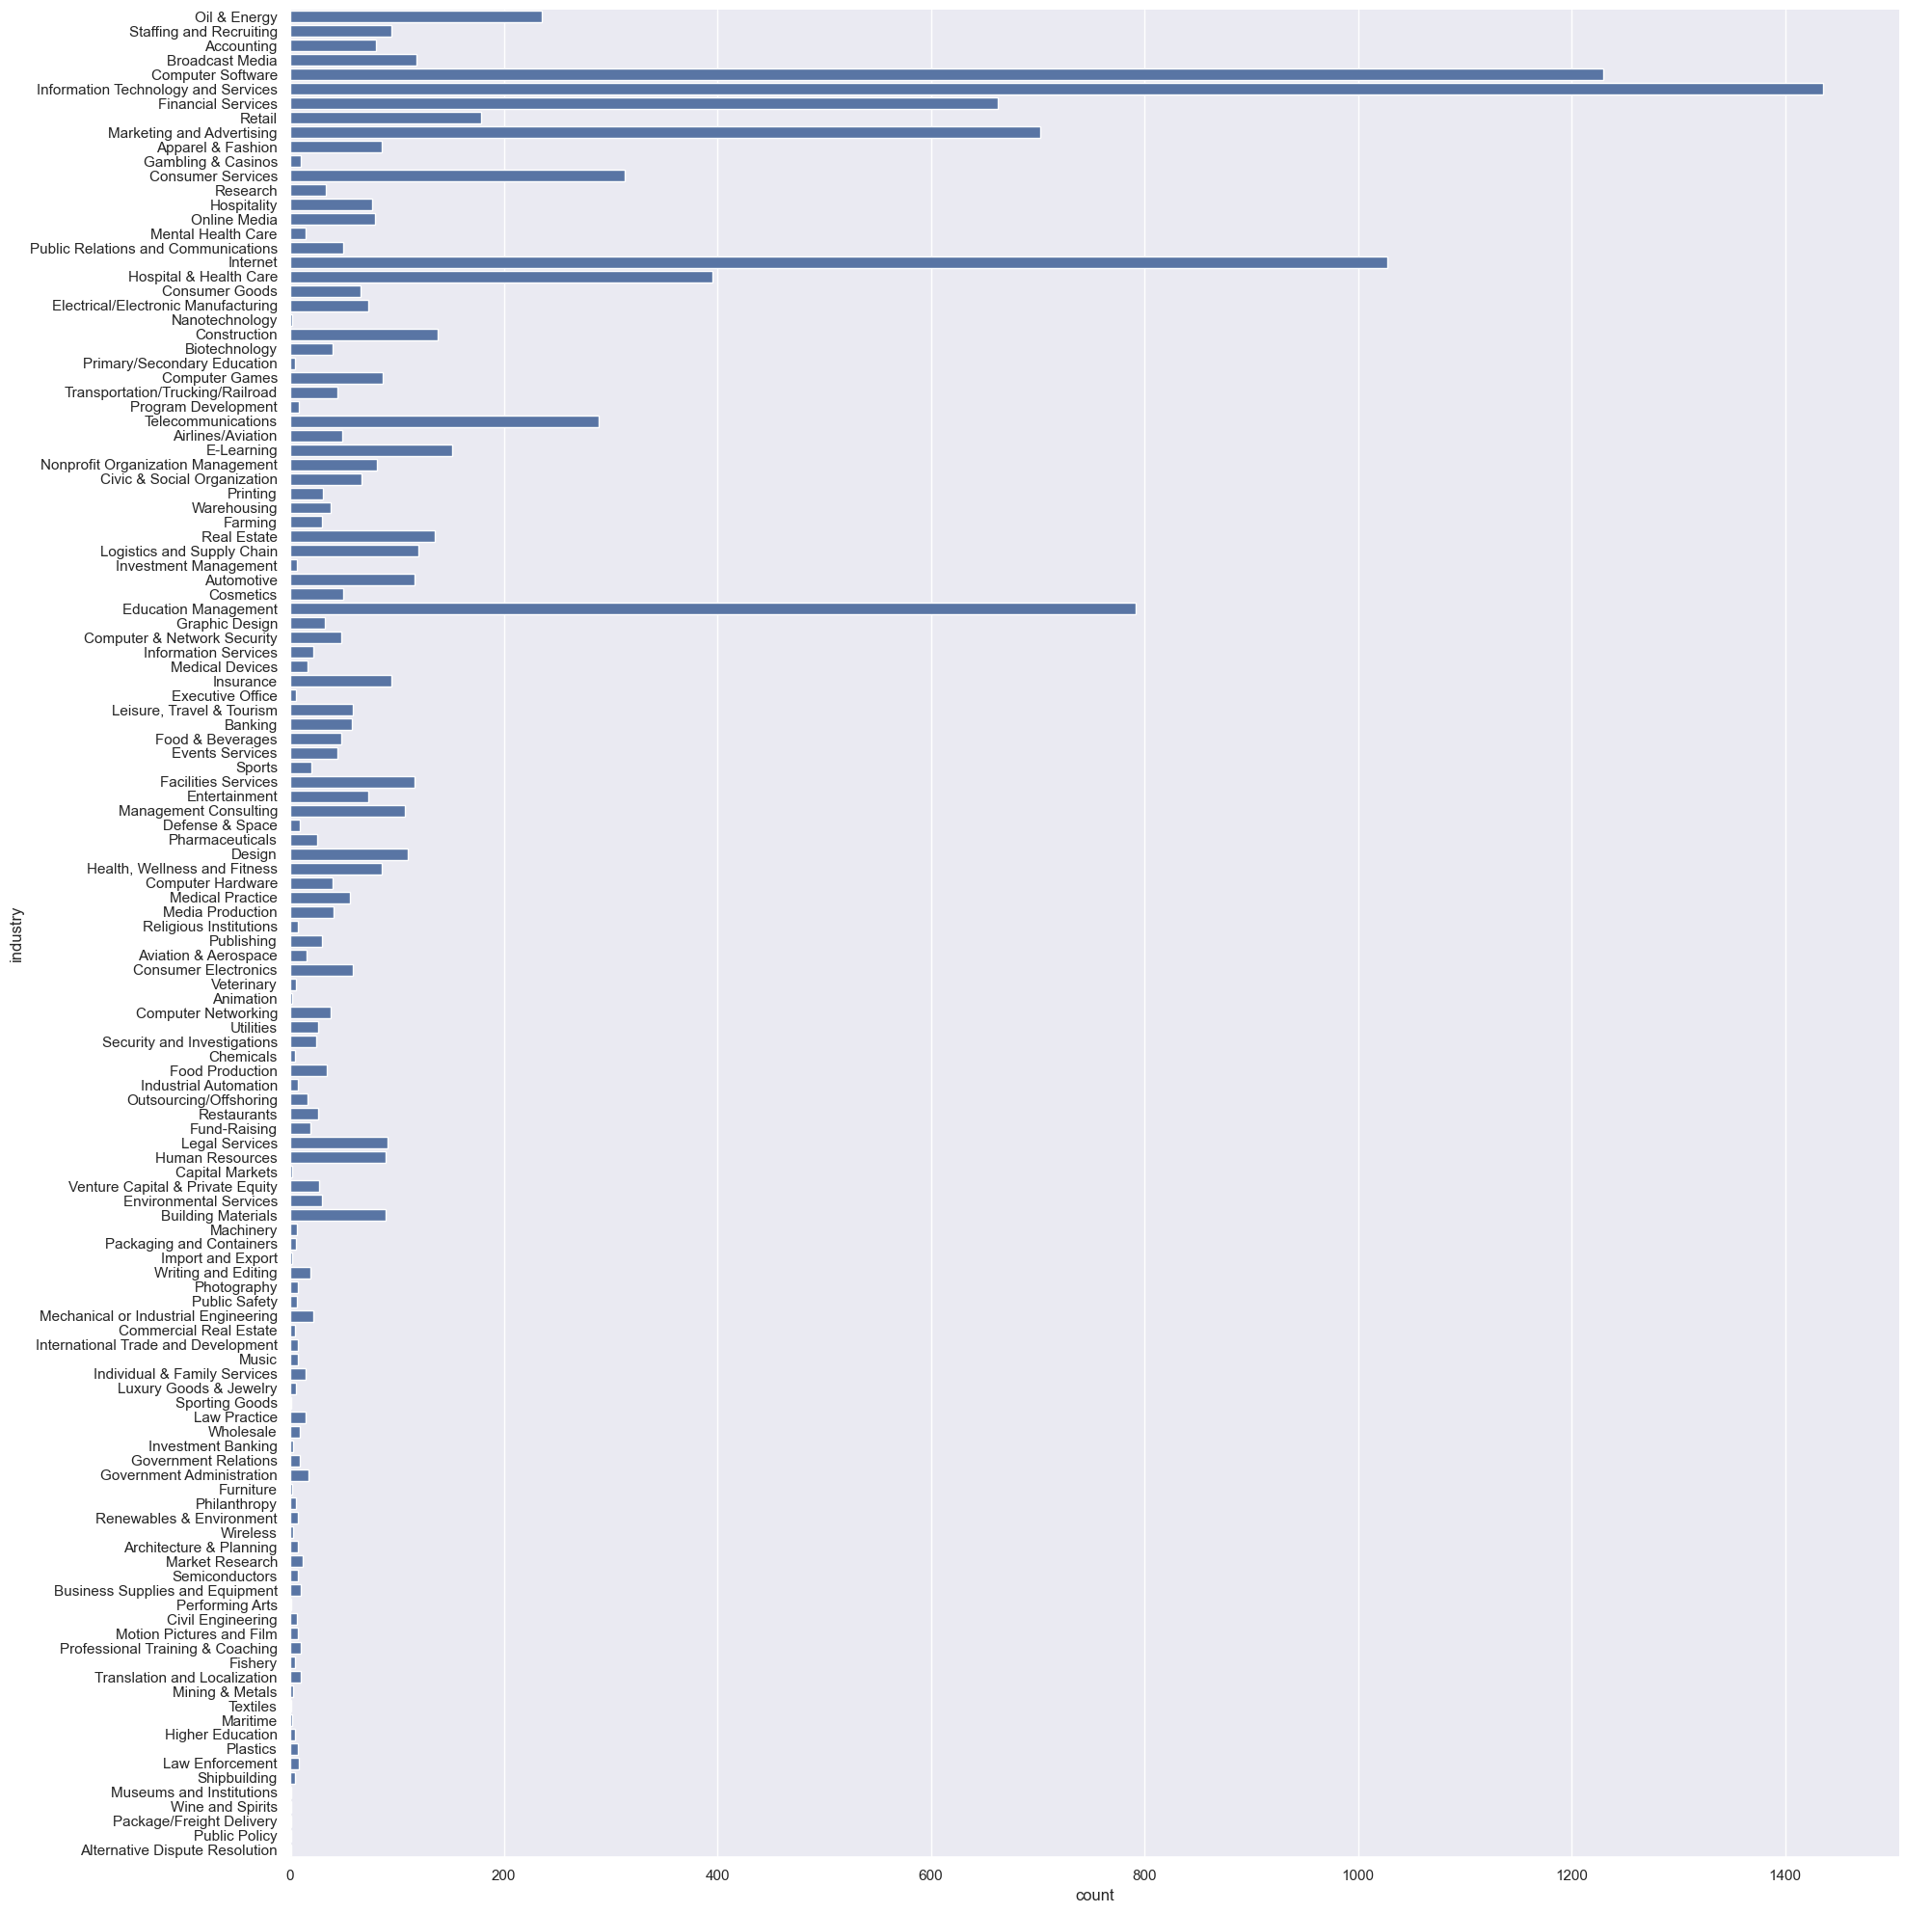

In [40]:
print(fjp2["industry"].value_counts())
sb.catplot(y = "industry", data = fjp2, kind = "count", height = 20)

### Analysis of Fake job postings

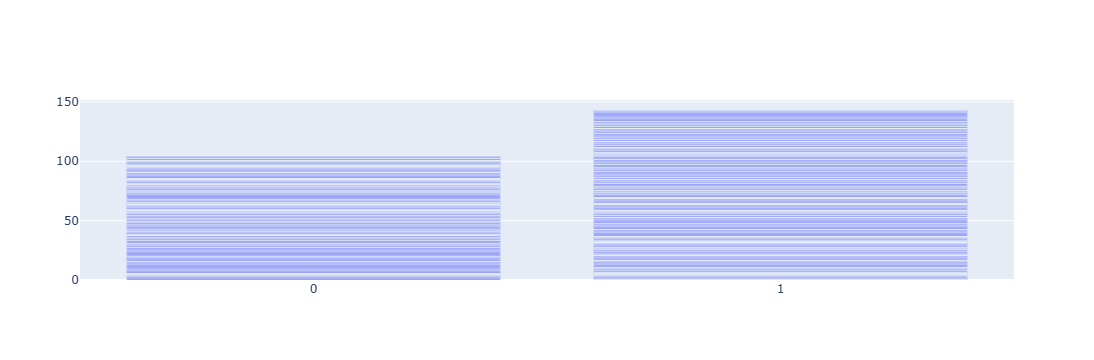

In [41]:
import plotly
from plotly.graph_objs import Bar, Scatter, Figure, Layout
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) 
import plotly.graph_objects as go

data = [go.Bar(x=fjp2.has_questions,
            y=fjp2.fraudulent)]

iplot(data)

#### Fake job postings are a serious problem in today's society, and it can be seen from the data visualizations above that most job postings revolve around jobs with technical characteristics such as information technology and engineering, so they are most vulnerable to fake job postings. It is also seen that technology industries such as IT, computer software and the internet dominate job postings, so these jobs are most vulnerable to fake posts as these are currently in high demand and even with so many job postings, the supply Still less than the market, this creates a perfect situation where scammers can step in and take advantage of these job applicants.

## Part C: Prediction (DS/ML)

In [43]:
df1 = pd.read_csv('fake_job_postings.csv')

In [44]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [45]:
df1 = df1.drop(columns = ['job_id'])

In [46]:
#filling null values, 'Not Applicable' and 'Unspecified' with 'Not Specified'
df1.fillna('Not Specified', inplace=True)
df1 = df1.replace(['Not Applicable','Unspecified'],'Not Specified')

In [47]:
#Label counts for each attribute
labelcountlist = []
for x in df1.columns:
        labelcountlist.append((len(df1[x].unique())))
labelcount = pd.DataFrame({'Attribute': df1.columns, 'Count': labelcountlist})
print(labelcount)

              Attribute  Count
0                 title  11231
1              location   3106
2            department   1338
3          salary_range    875
4       company_profile   1710
5           description  14802
6          requirements  11968
7              benefits   6205
8         telecommuting      2
9      has_company_logo      2
10        has_questions      2
11      employment_type      6
12  required_experience      7
13   required_education     13
14             industry    132
15             function     38
16           fraudulent      2


In [48]:
df1.head(15)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,Not Specified,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Not Specified,0,1,0,Other,Internship,Not Specified,Not Specified,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,Not Specified,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Specified,Not Specified,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Not Specified,Not Specified,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Not Specified,0,1,0,Not Specified,Not Specified,Not Specified,Not Specified,Not Specified,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Not Specified,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",Not Specified,Not Specified,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,Accounting Clerk,"US, MD,",Not Specified,Not Specified,Not Specified,Job OverviewApex is an environmental consultin...,Not Specified,Not Specified,0,0,0,Not Specified,Not Specified,Not Specified,Not Specified,Not Specified,0
6,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,Lead Guest Service Specialist,"US, CA, San Francisco",Not Specified,Not Specified,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,Not Specified,Not Specified,Not Specified,Not Specified,Not Specified,0
8,HP BSM SME,"US, FL, Pensacola",Not Specified,Not Specified,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,Not Specified,0,1,1,Full-time,Associate,Not Specified,Information Technology and Services,Not Specified,0
9,Customer Service Associate - Part Time,"US, AZ, Phoenix",Not Specified,Not Specified,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,Not Specified,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0


In [49]:
#STORING ALL THOSE ATTRIBUTES WITH LESS THAN 100 LABELS FOR COMPREHENSIBLE VISUALIZATION USING BAR GRAPHS
#AlSO DISPLAYS THE COUNT OF EVERY LABEL IN EACH ATTRIBUTE
print(labelcount[labelcount['Count'] < 100])
count = 0
label = []
for x in df1.columns:
    if len(df1[x].unique()) < 100:
        print('\n' + x + '\n----------\n' + str(list(df1[x].unique())) + "\n")
        print(df1[x].value_counts())
        label.append(x)

              Attribute  Count
8         telecommuting      2
9      has_company_logo      2
10        has_questions      2
11      employment_type      6
12  required_experience      7
13   required_education     13
15             function     38
16           fraudulent      2

telecommuting
----------
[np.int64(0), np.int64(1)]

telecommuting
0    17113
1      767
Name: count, dtype: int64

has_company_logo
----------
[np.int64(1), np.int64(0)]

has_company_logo
1    14220
0     3660
Name: count, dtype: int64

has_questions
----------
[np.int64(0), np.int64(1)]

has_questions
0    9088
1    8792
Name: count, dtype: int64

employment_type
----------
['Other', 'Full-time', 'Not Specified', 'Part-time', 'Contract', 'Temporary']

employment_type
Full-time        11620
Not Specified     3471
Contract          1524
Part-time          797
Temporary          241
Other              227
Name: count, dtype: int64

required_experience
----------
['Internship', 'Not Specified', 'Mid-Senior level'

In [50]:
label.remove('fraudulent')
print(label)

['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'function']


In [54]:
#FUNCTION TO PLOT ATTRIBUTE vs KEY LABEL GRAPHS FOR ATTRIBUTES IN label[]
def plots(lab1,lab2):
    #lab1 = label[0]
    #lab2 = 'fraudulent'
    sb.set(rc={'figure.figsize':(20,40)})
    ax = sb.countplot(data = df1,x=df1[lab1],hue=df1[lab2])

    for p in ax.patches:
       ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.xticks(rotation=90)

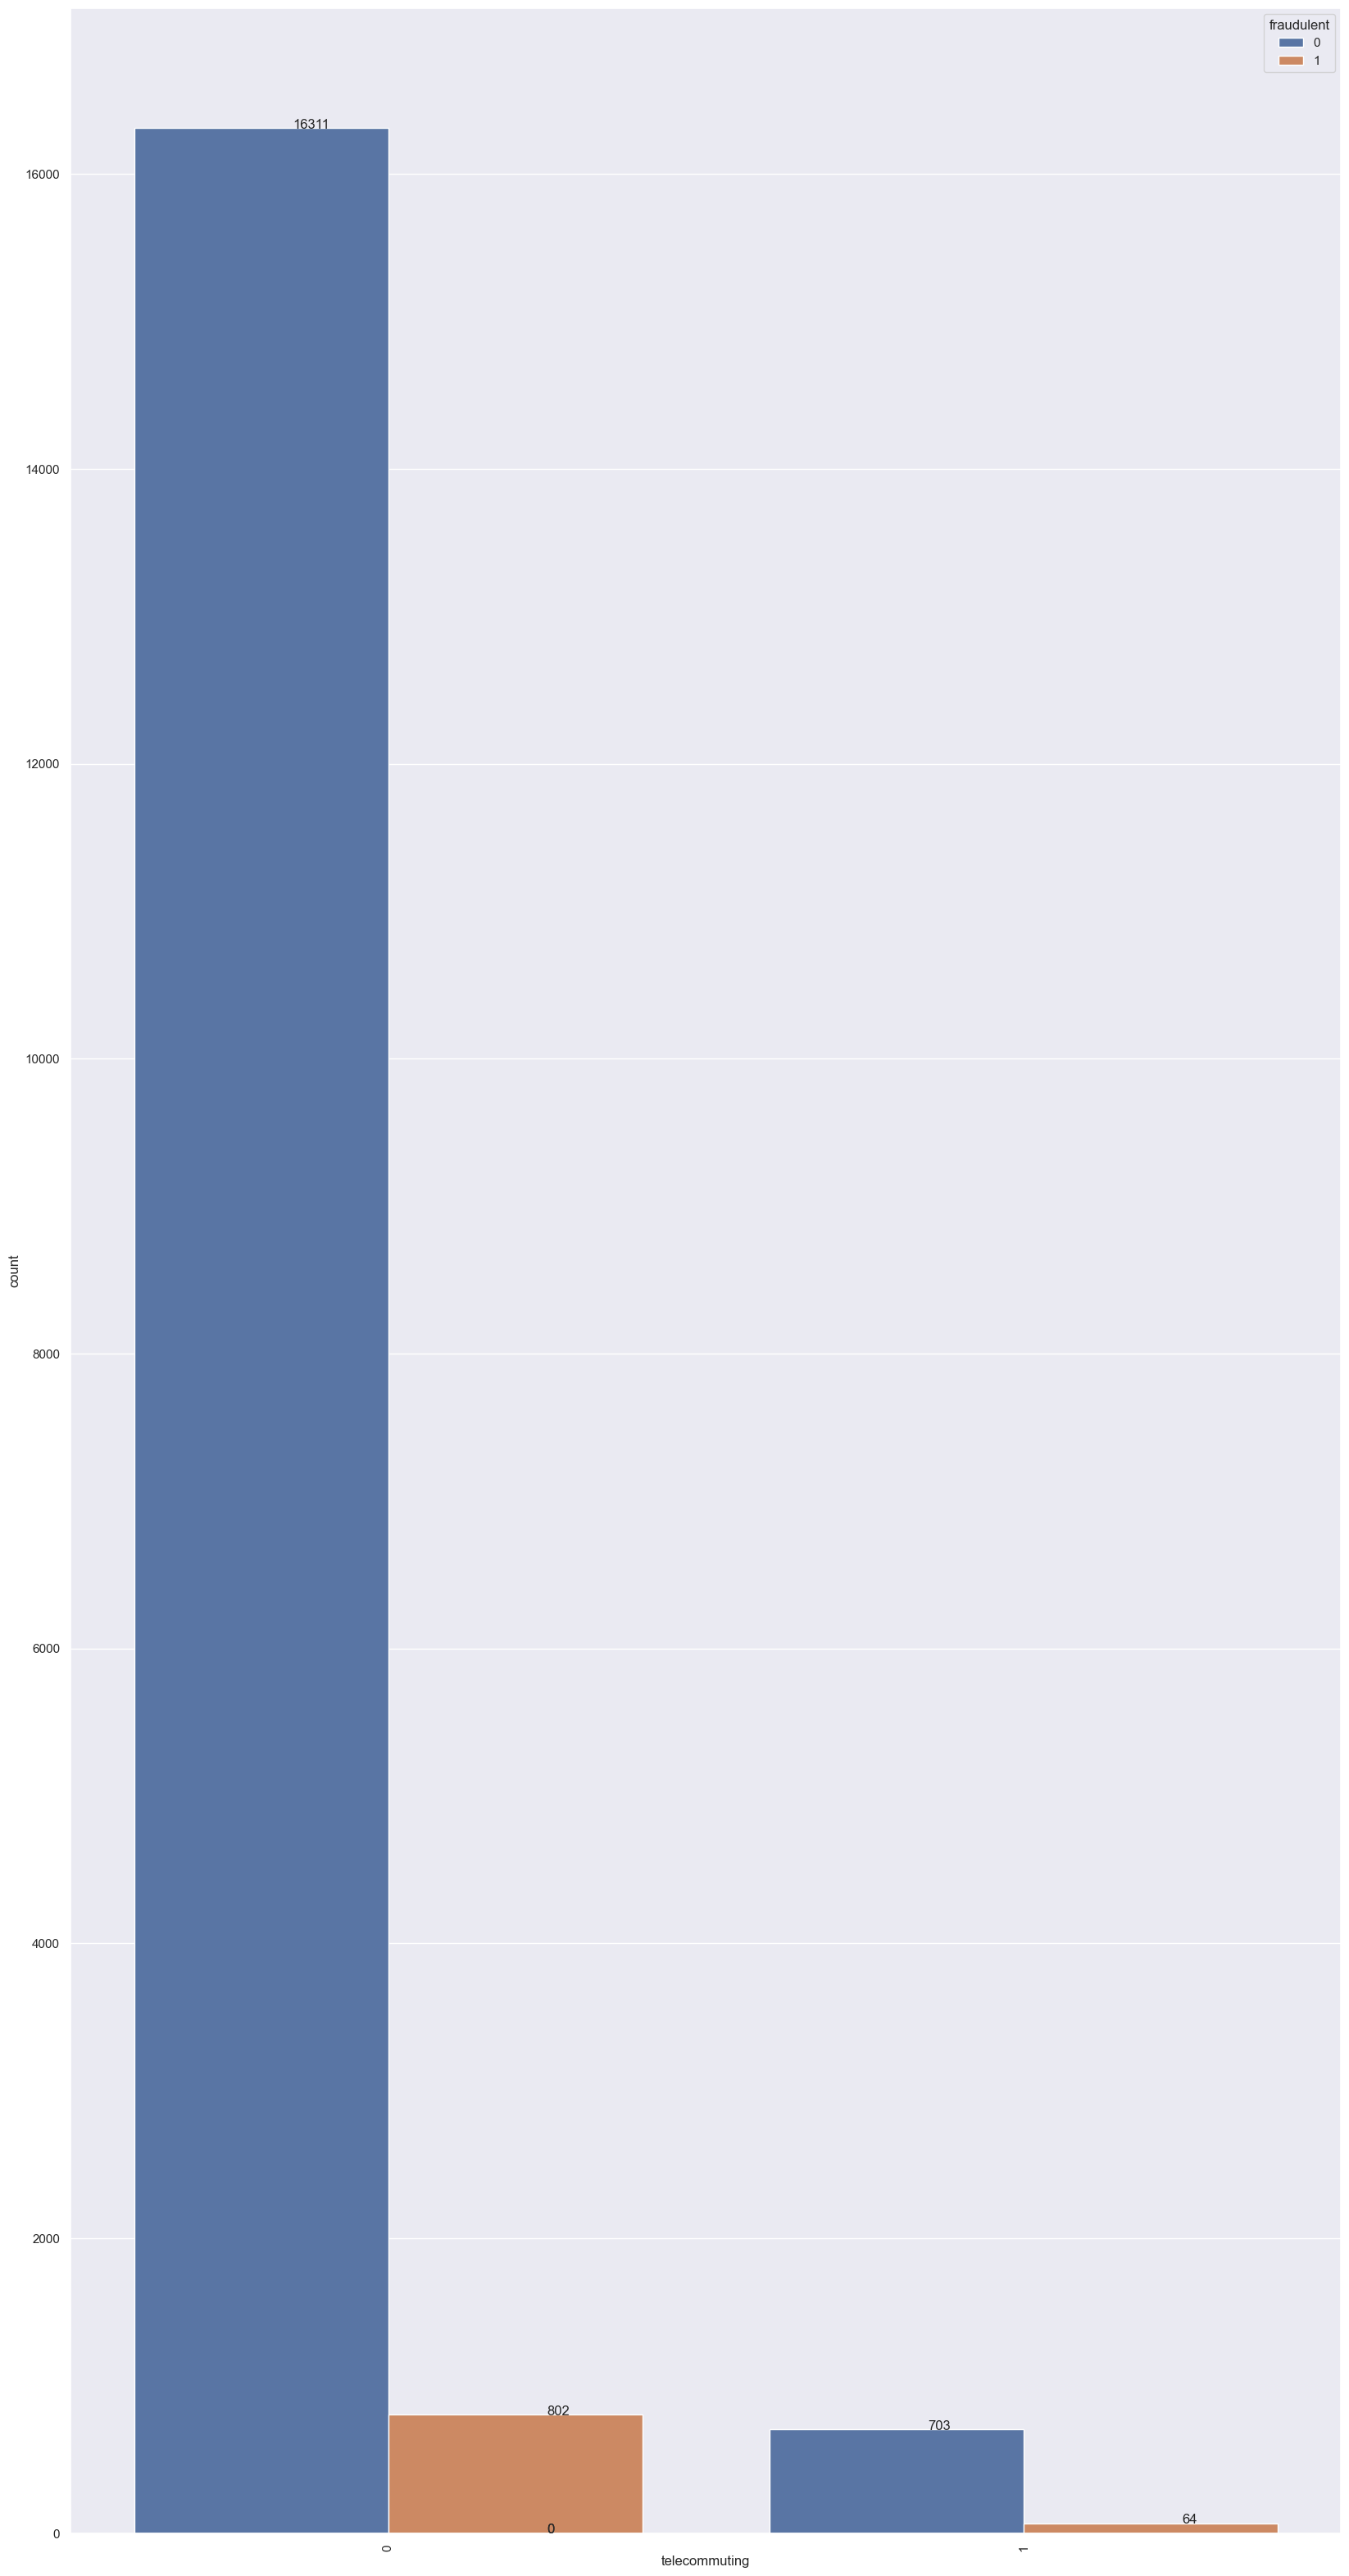

In [55]:
plots(label[0],'fraudulent')#telecommuting

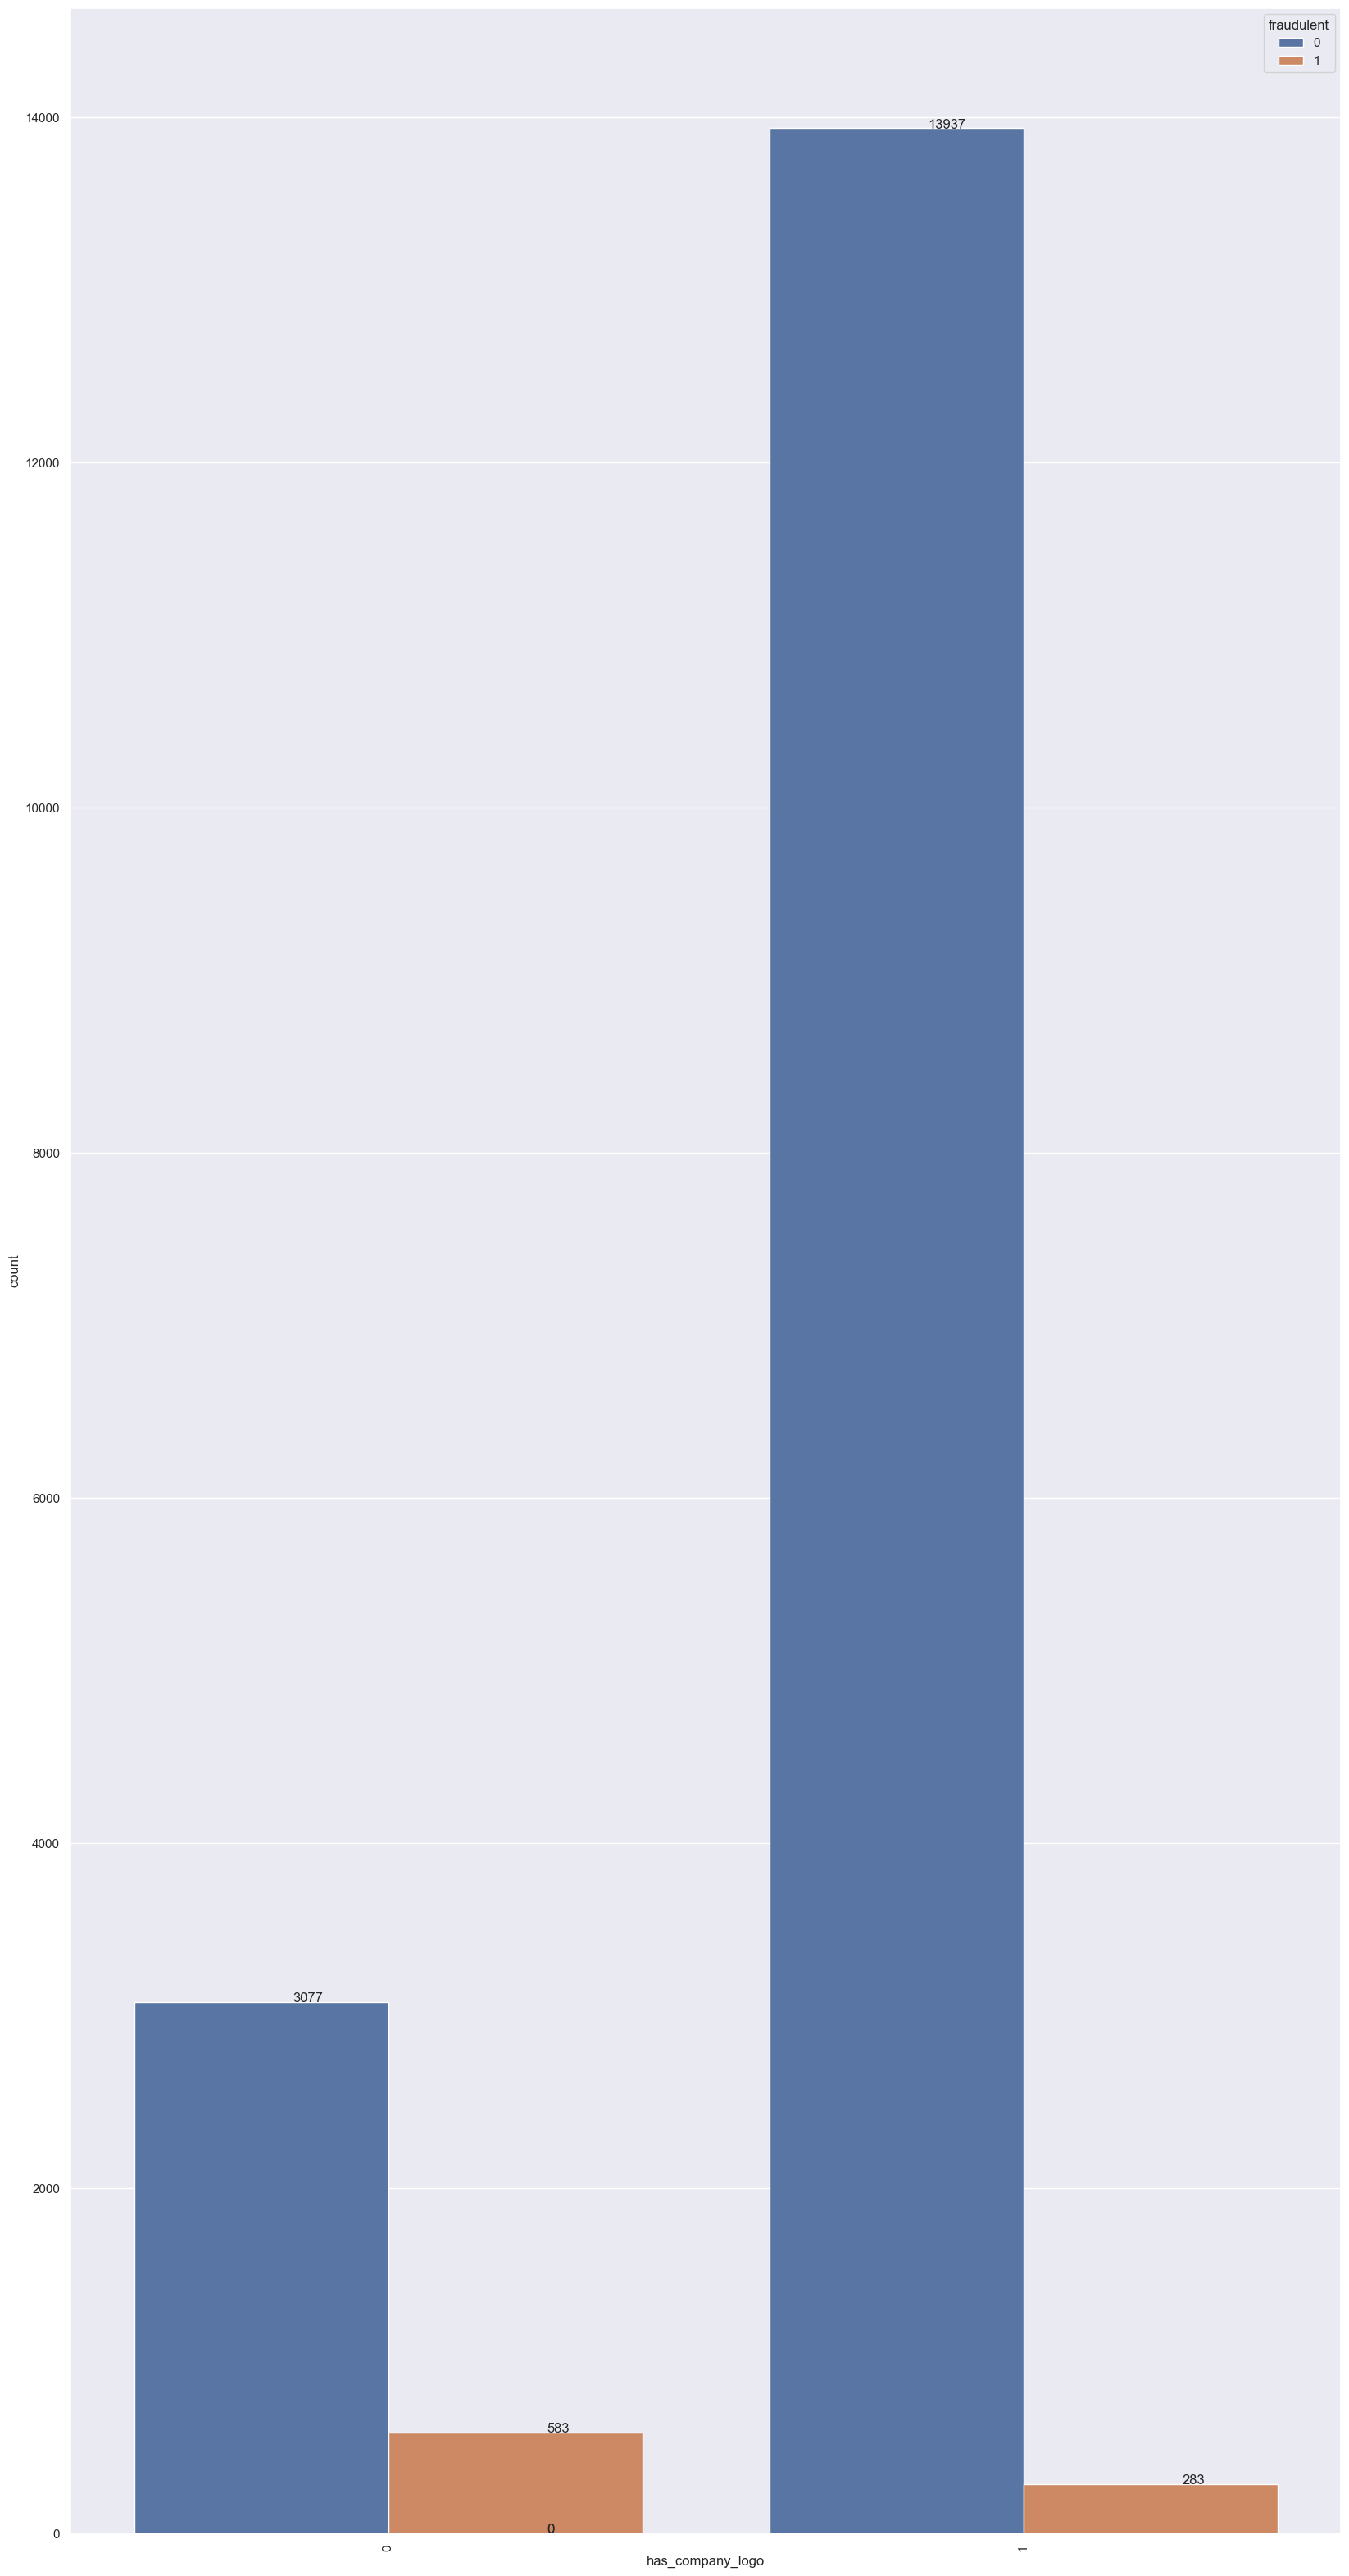

In [56]:
plots(label[1],'fraudulent')#has_company_logo

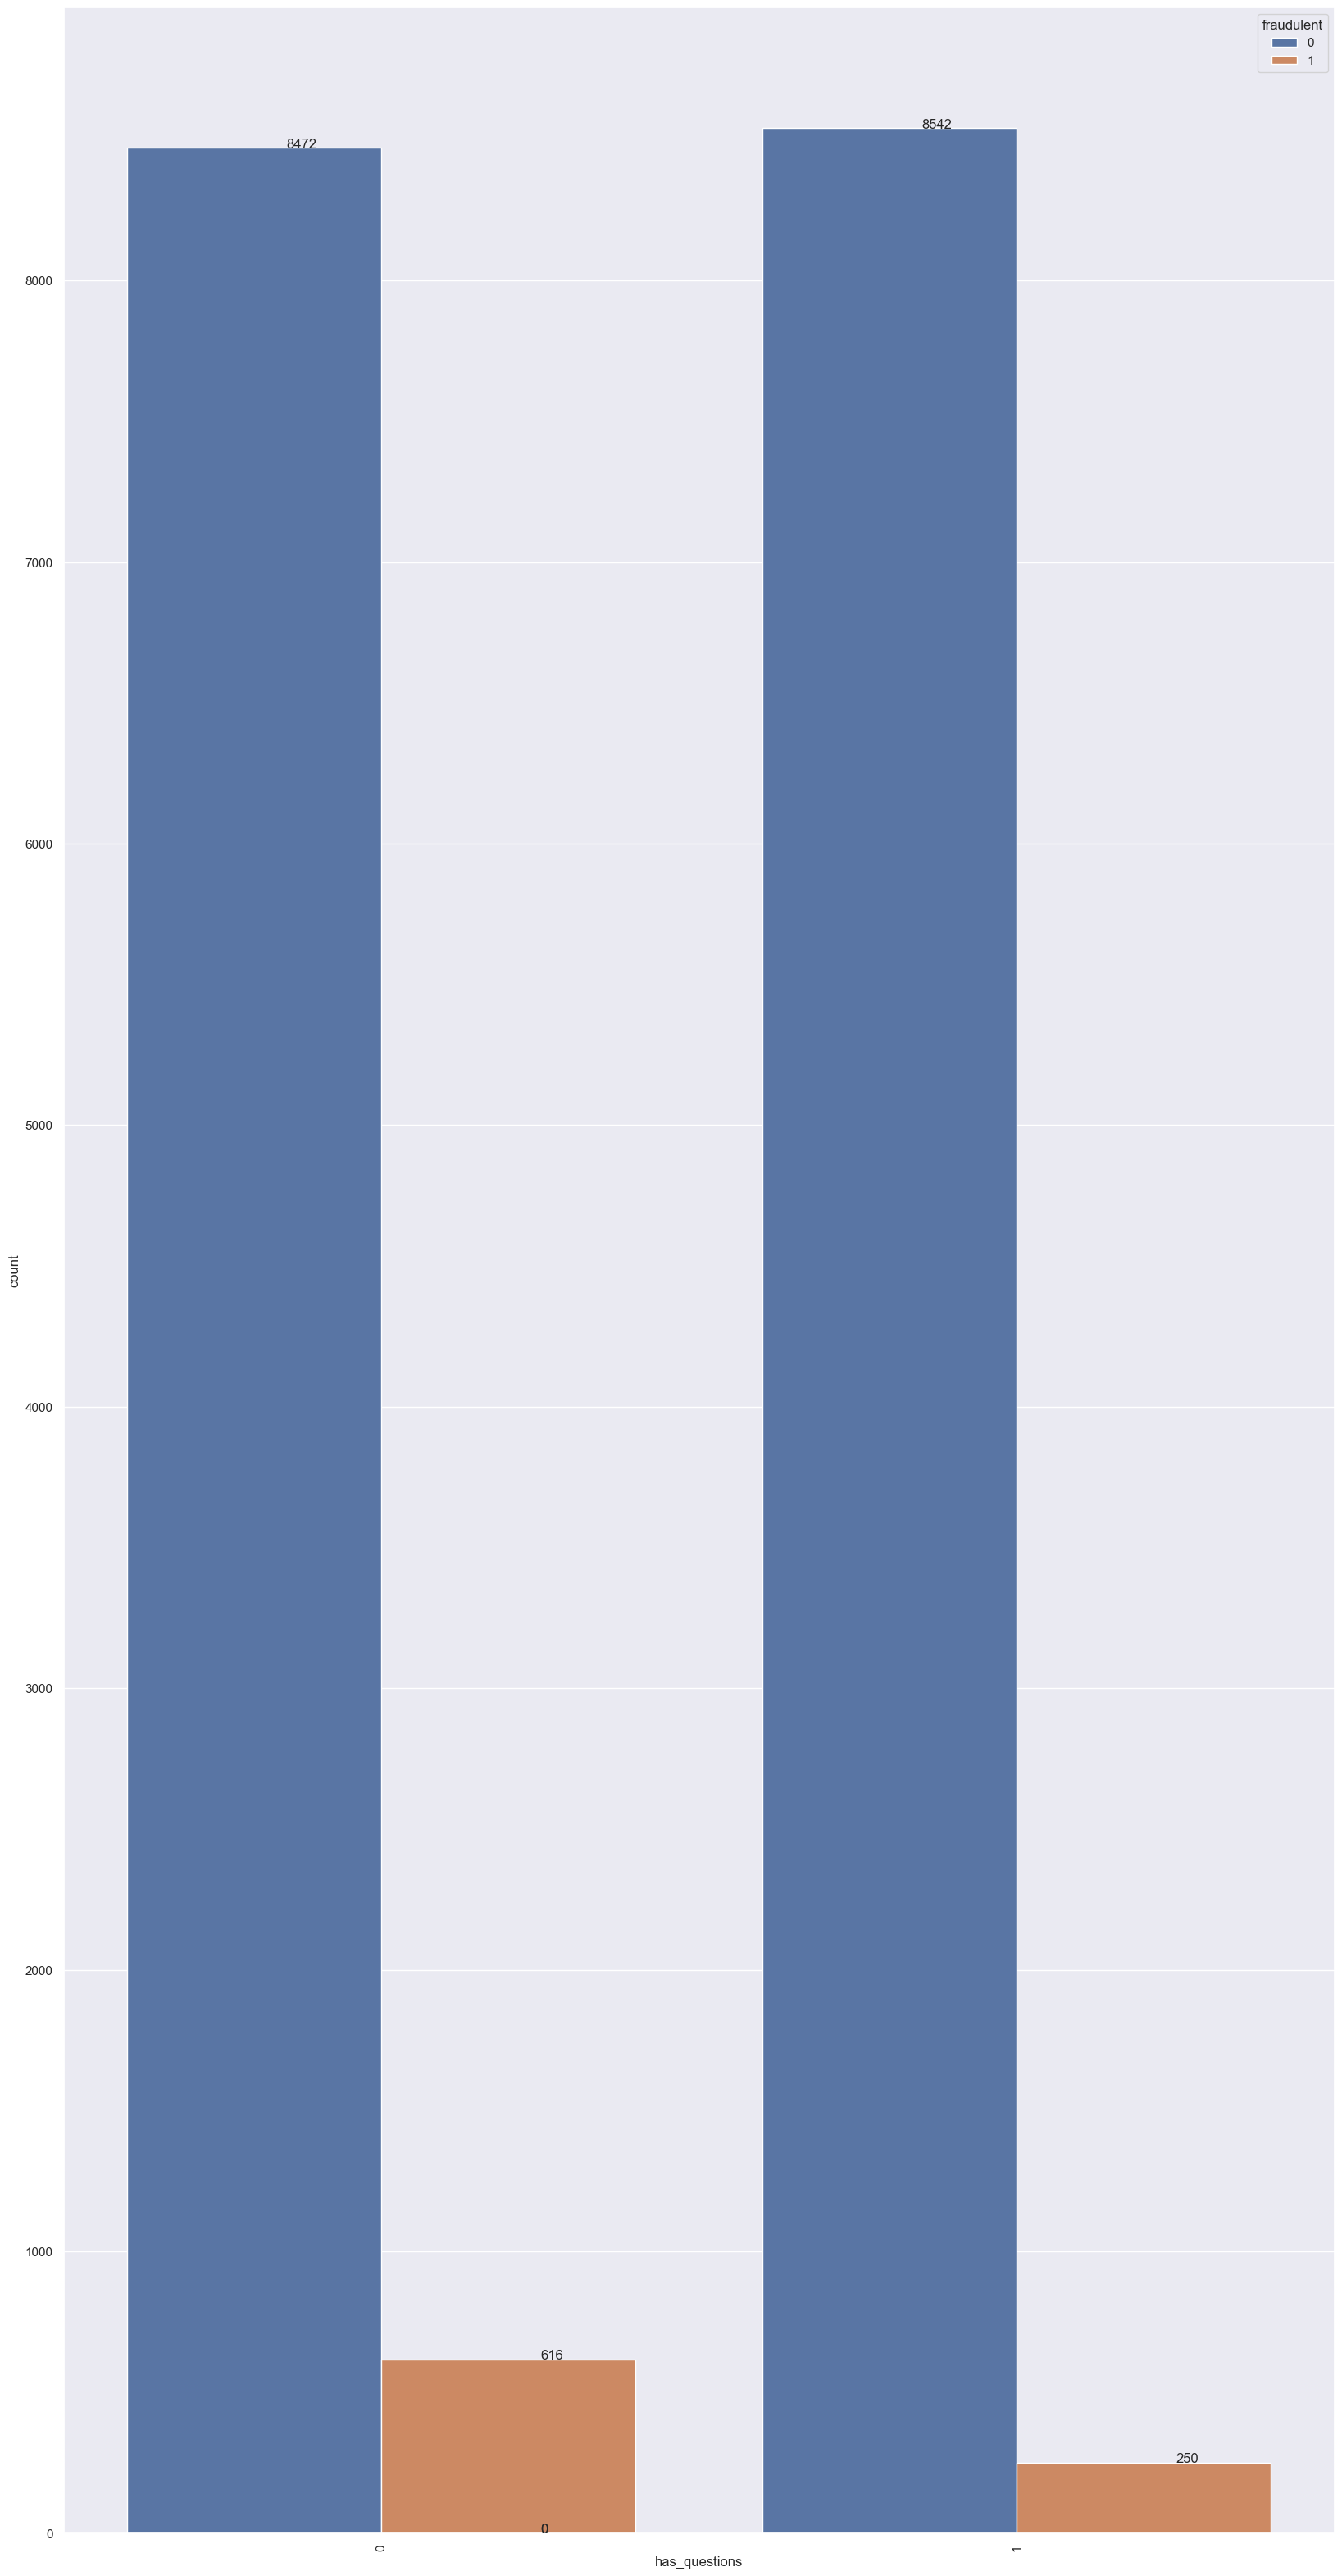

In [57]:
plots(label[2],'fraudulent')#has_questions

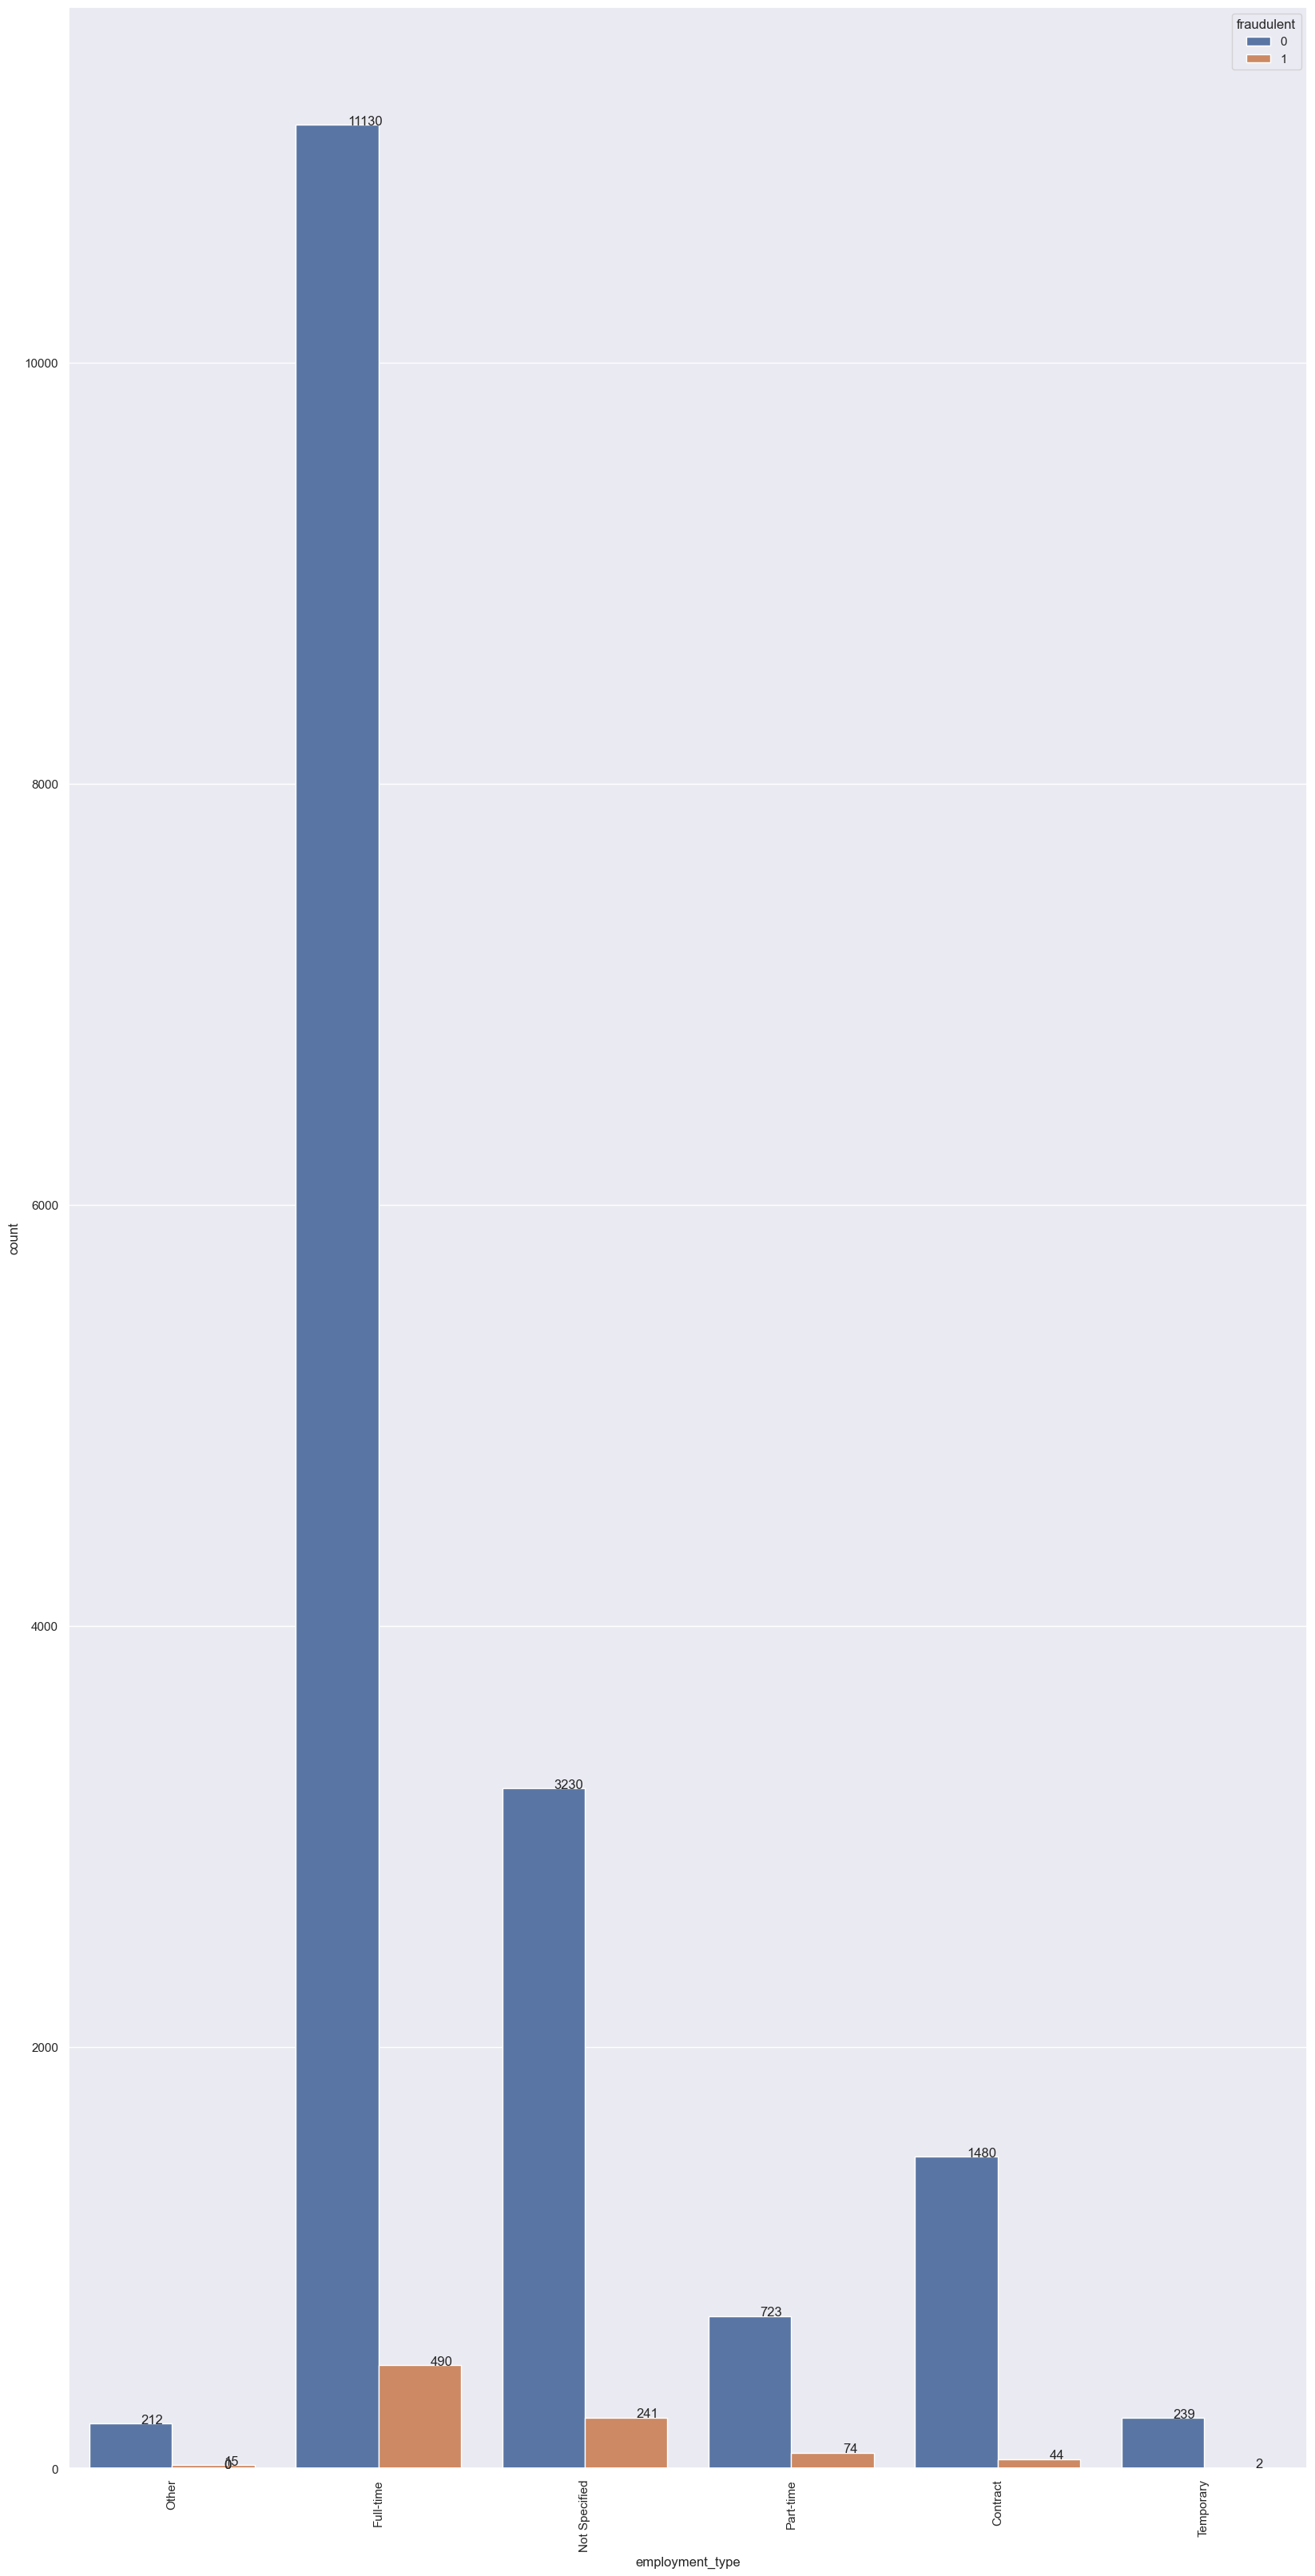

In [58]:
plots(label[3],'fraudulent')#employement_type

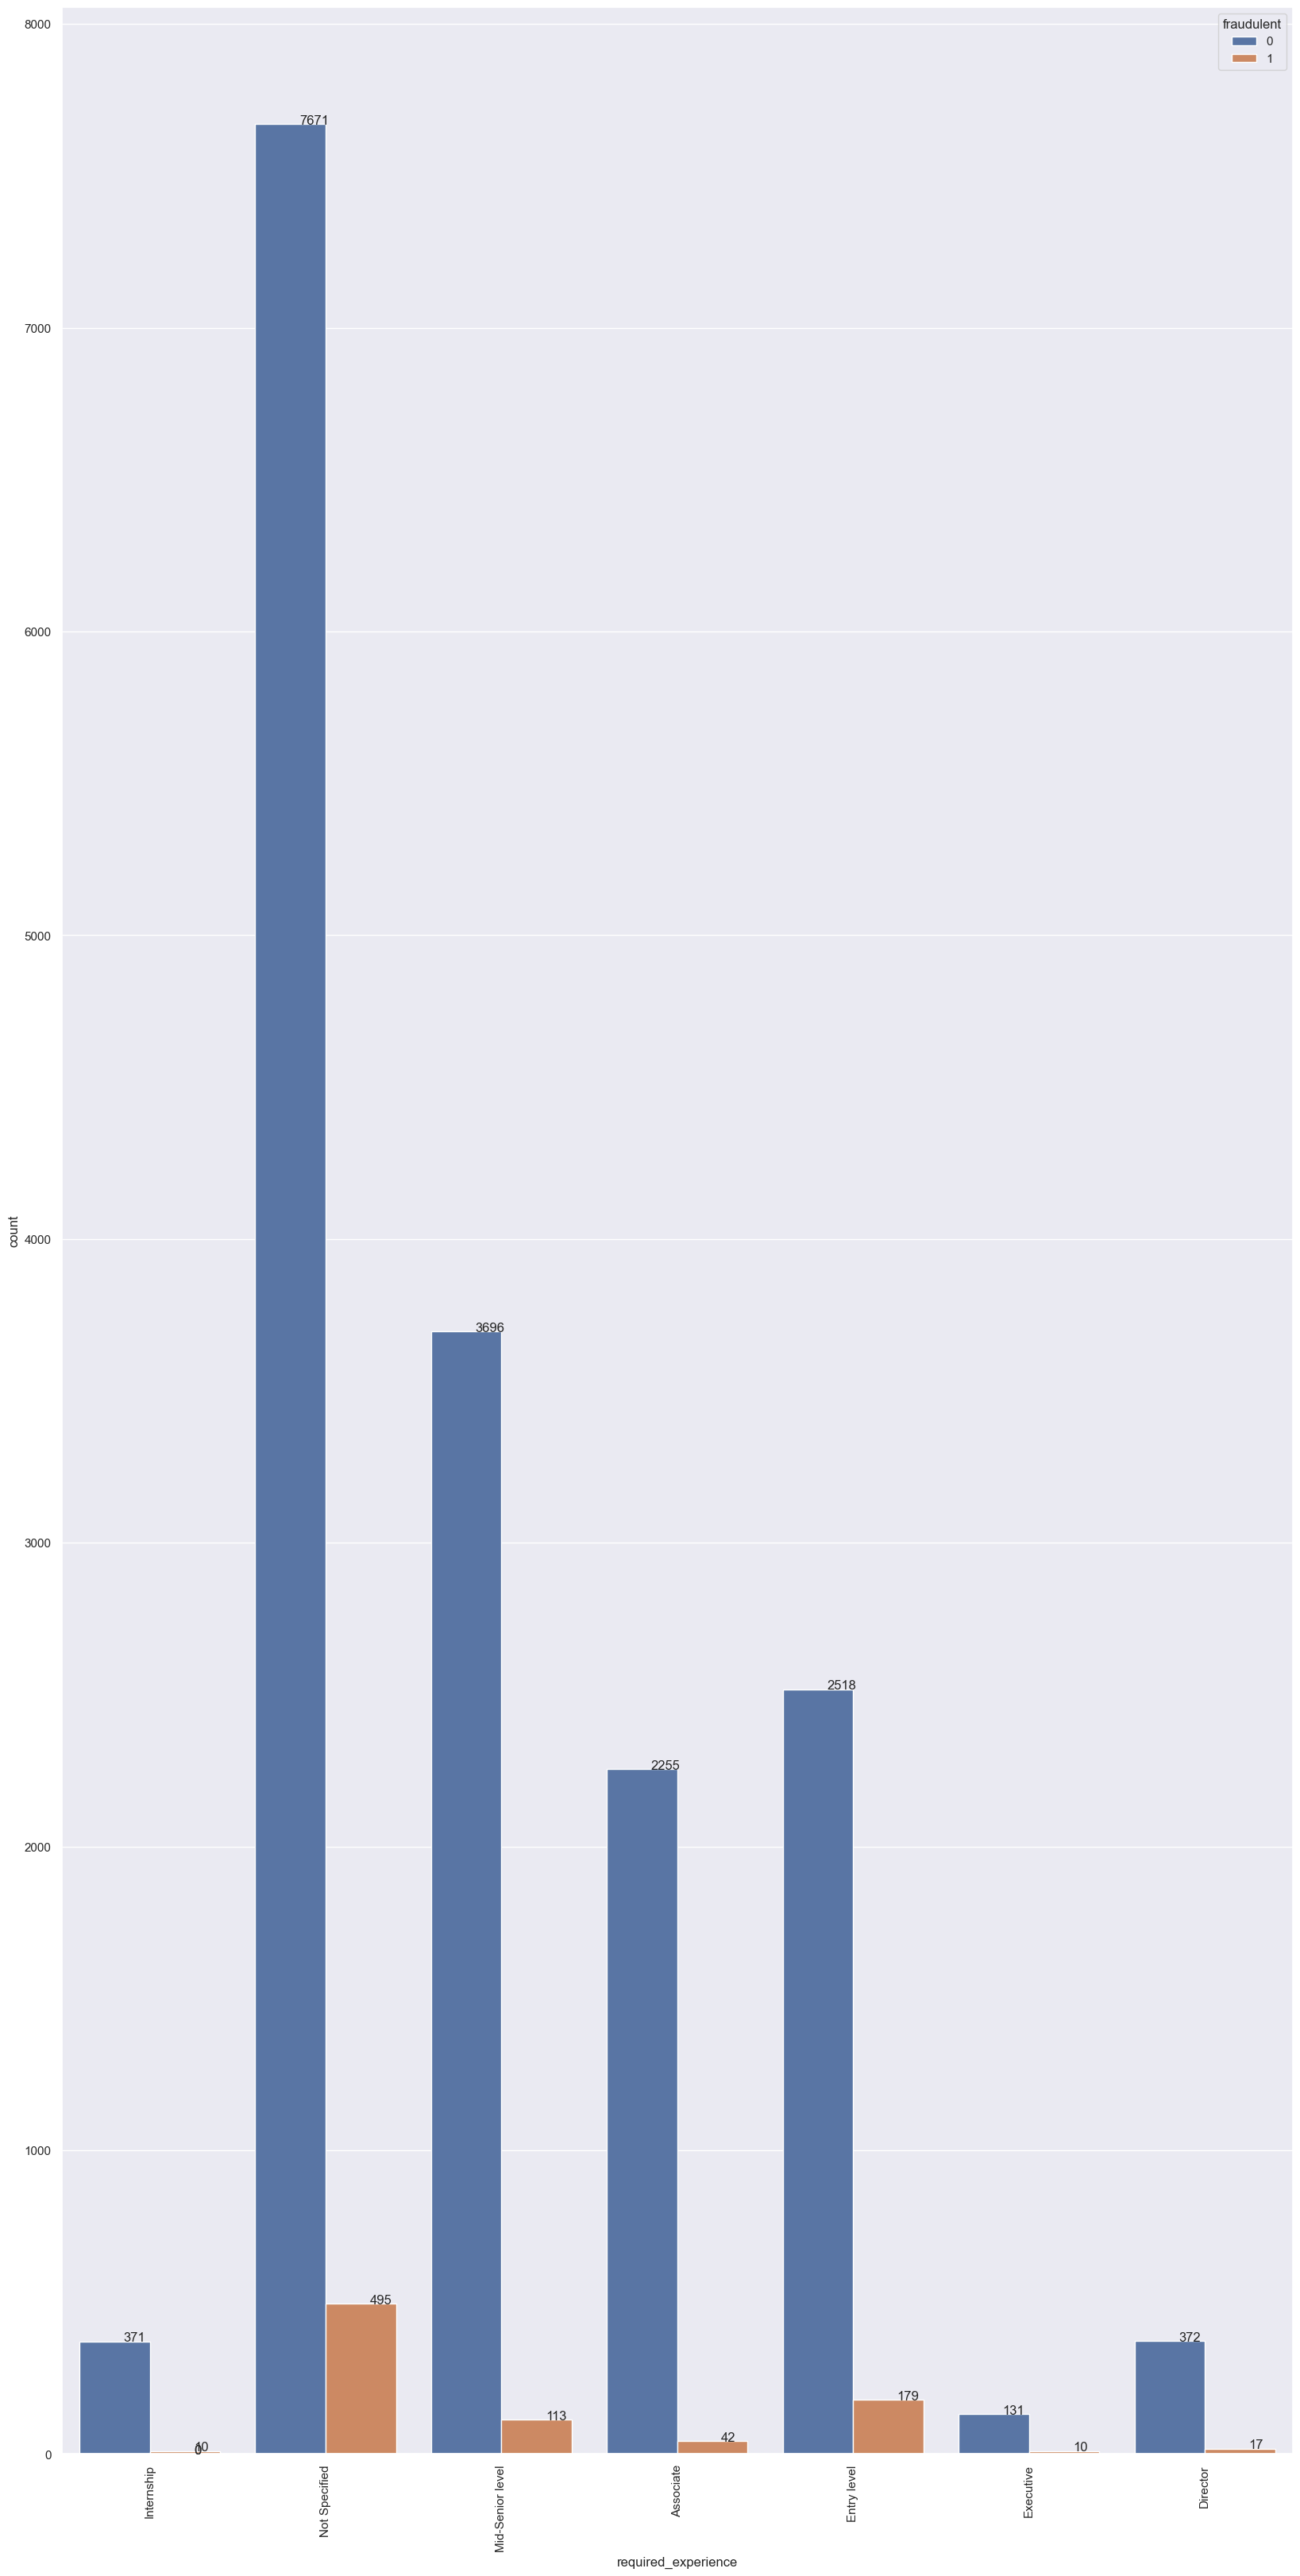

In [59]:
plots(label[4],'fraudulent')#required_experience

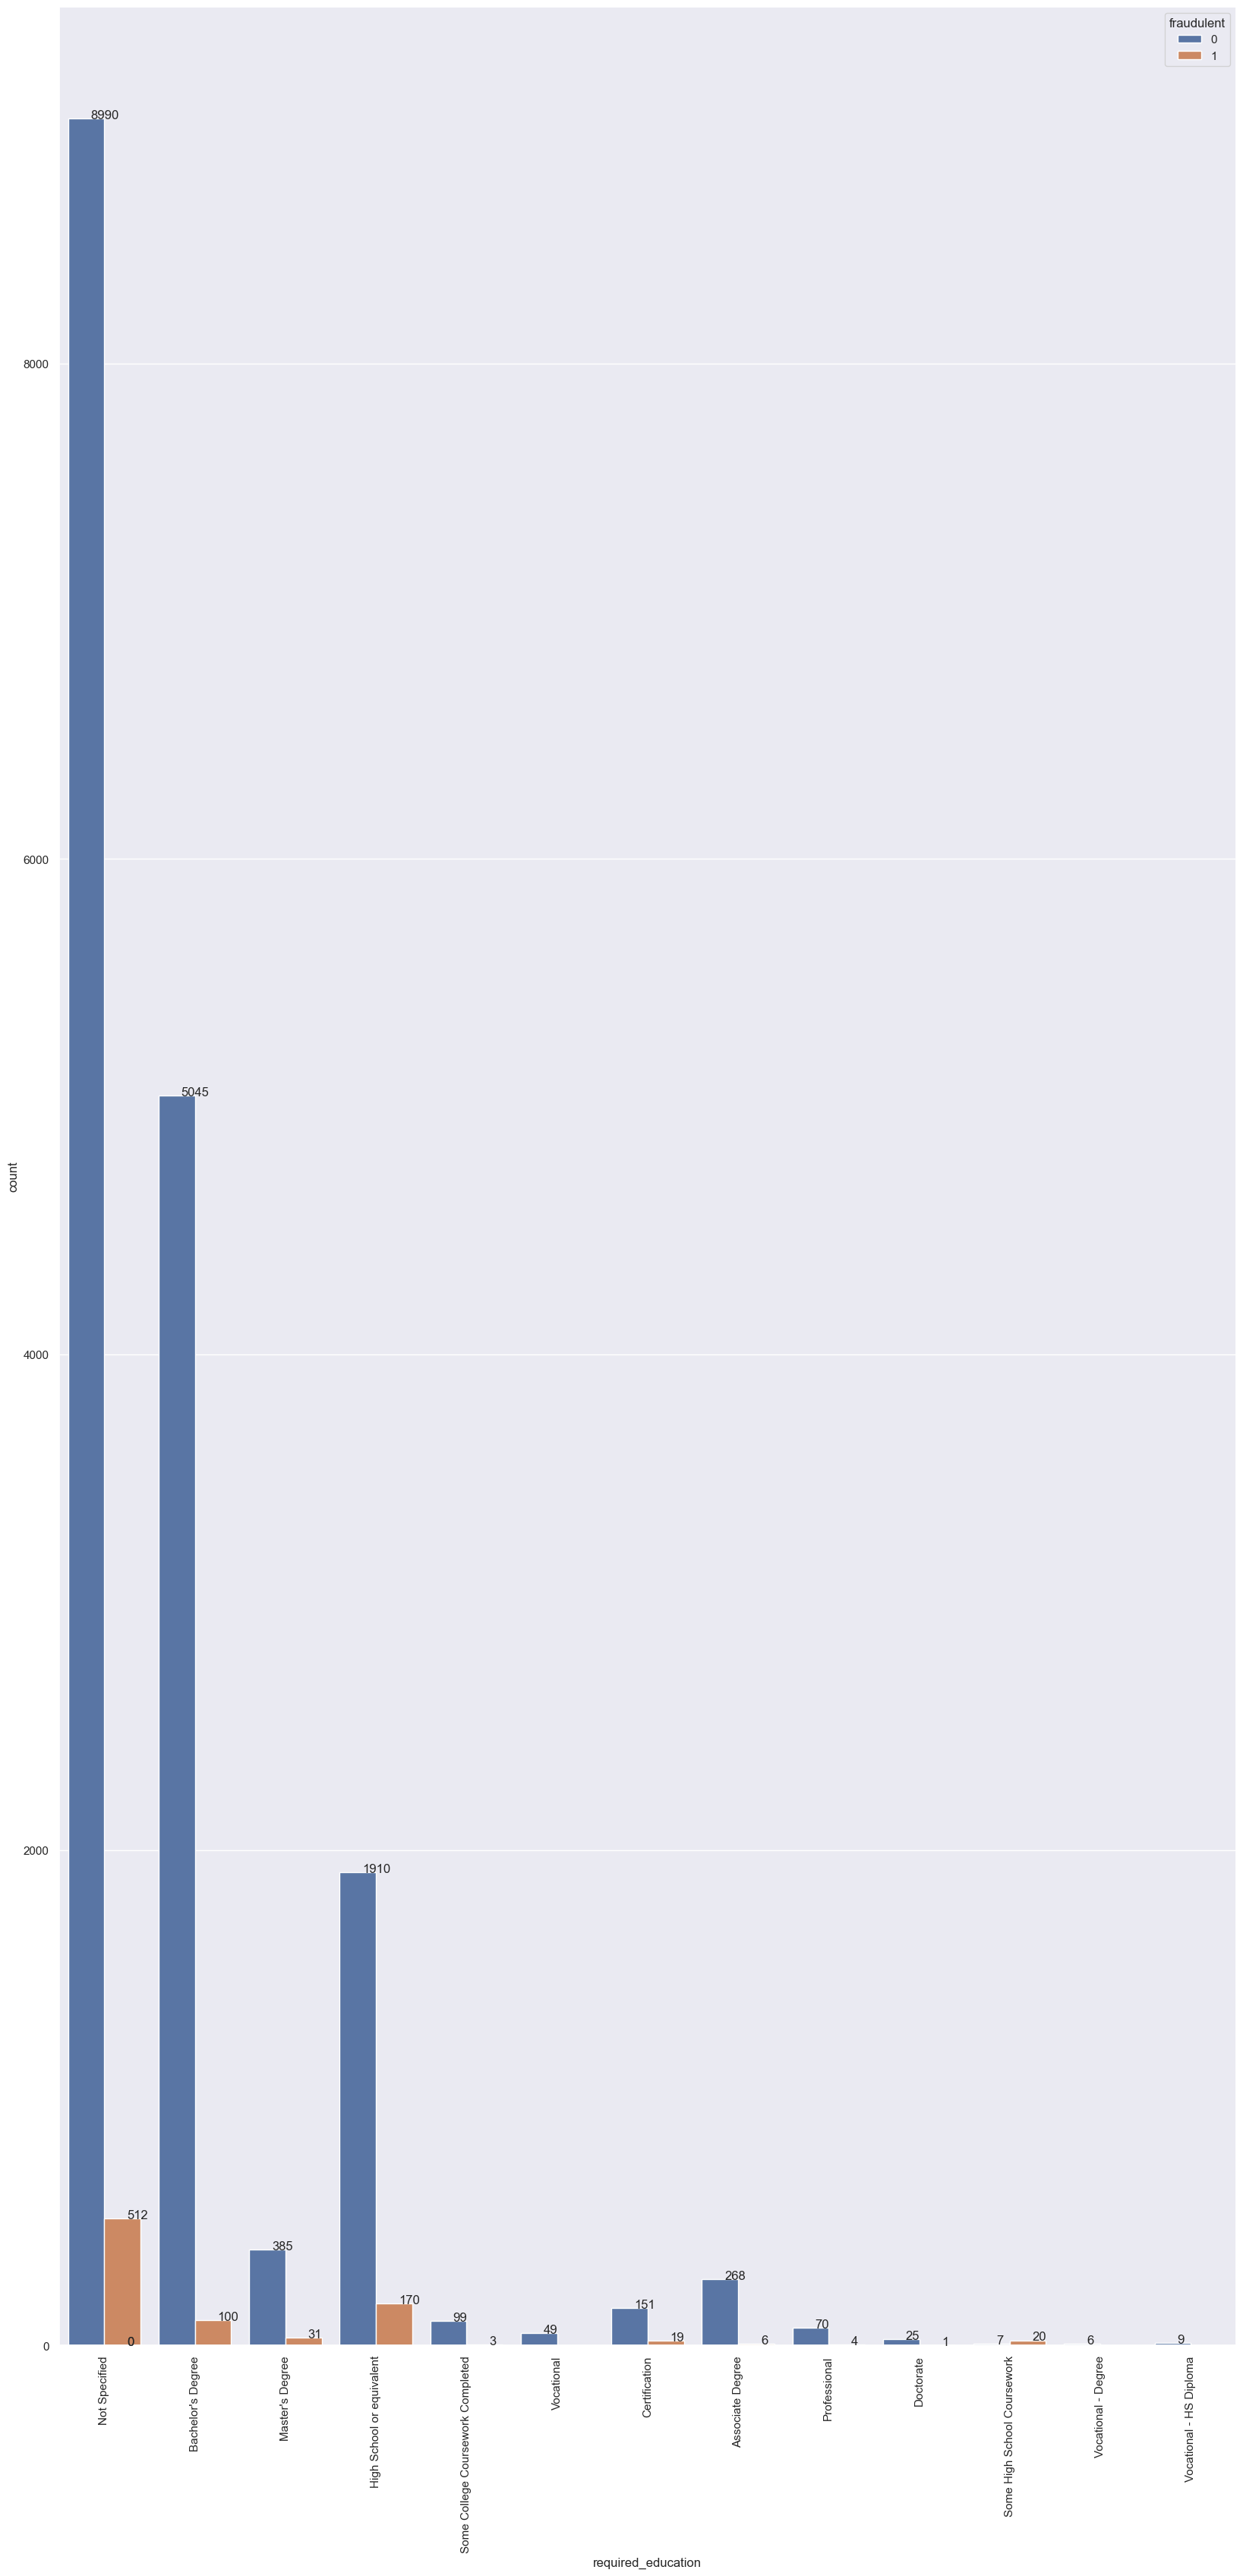

In [60]:
plots(label[5],'fraudulent')#required_education

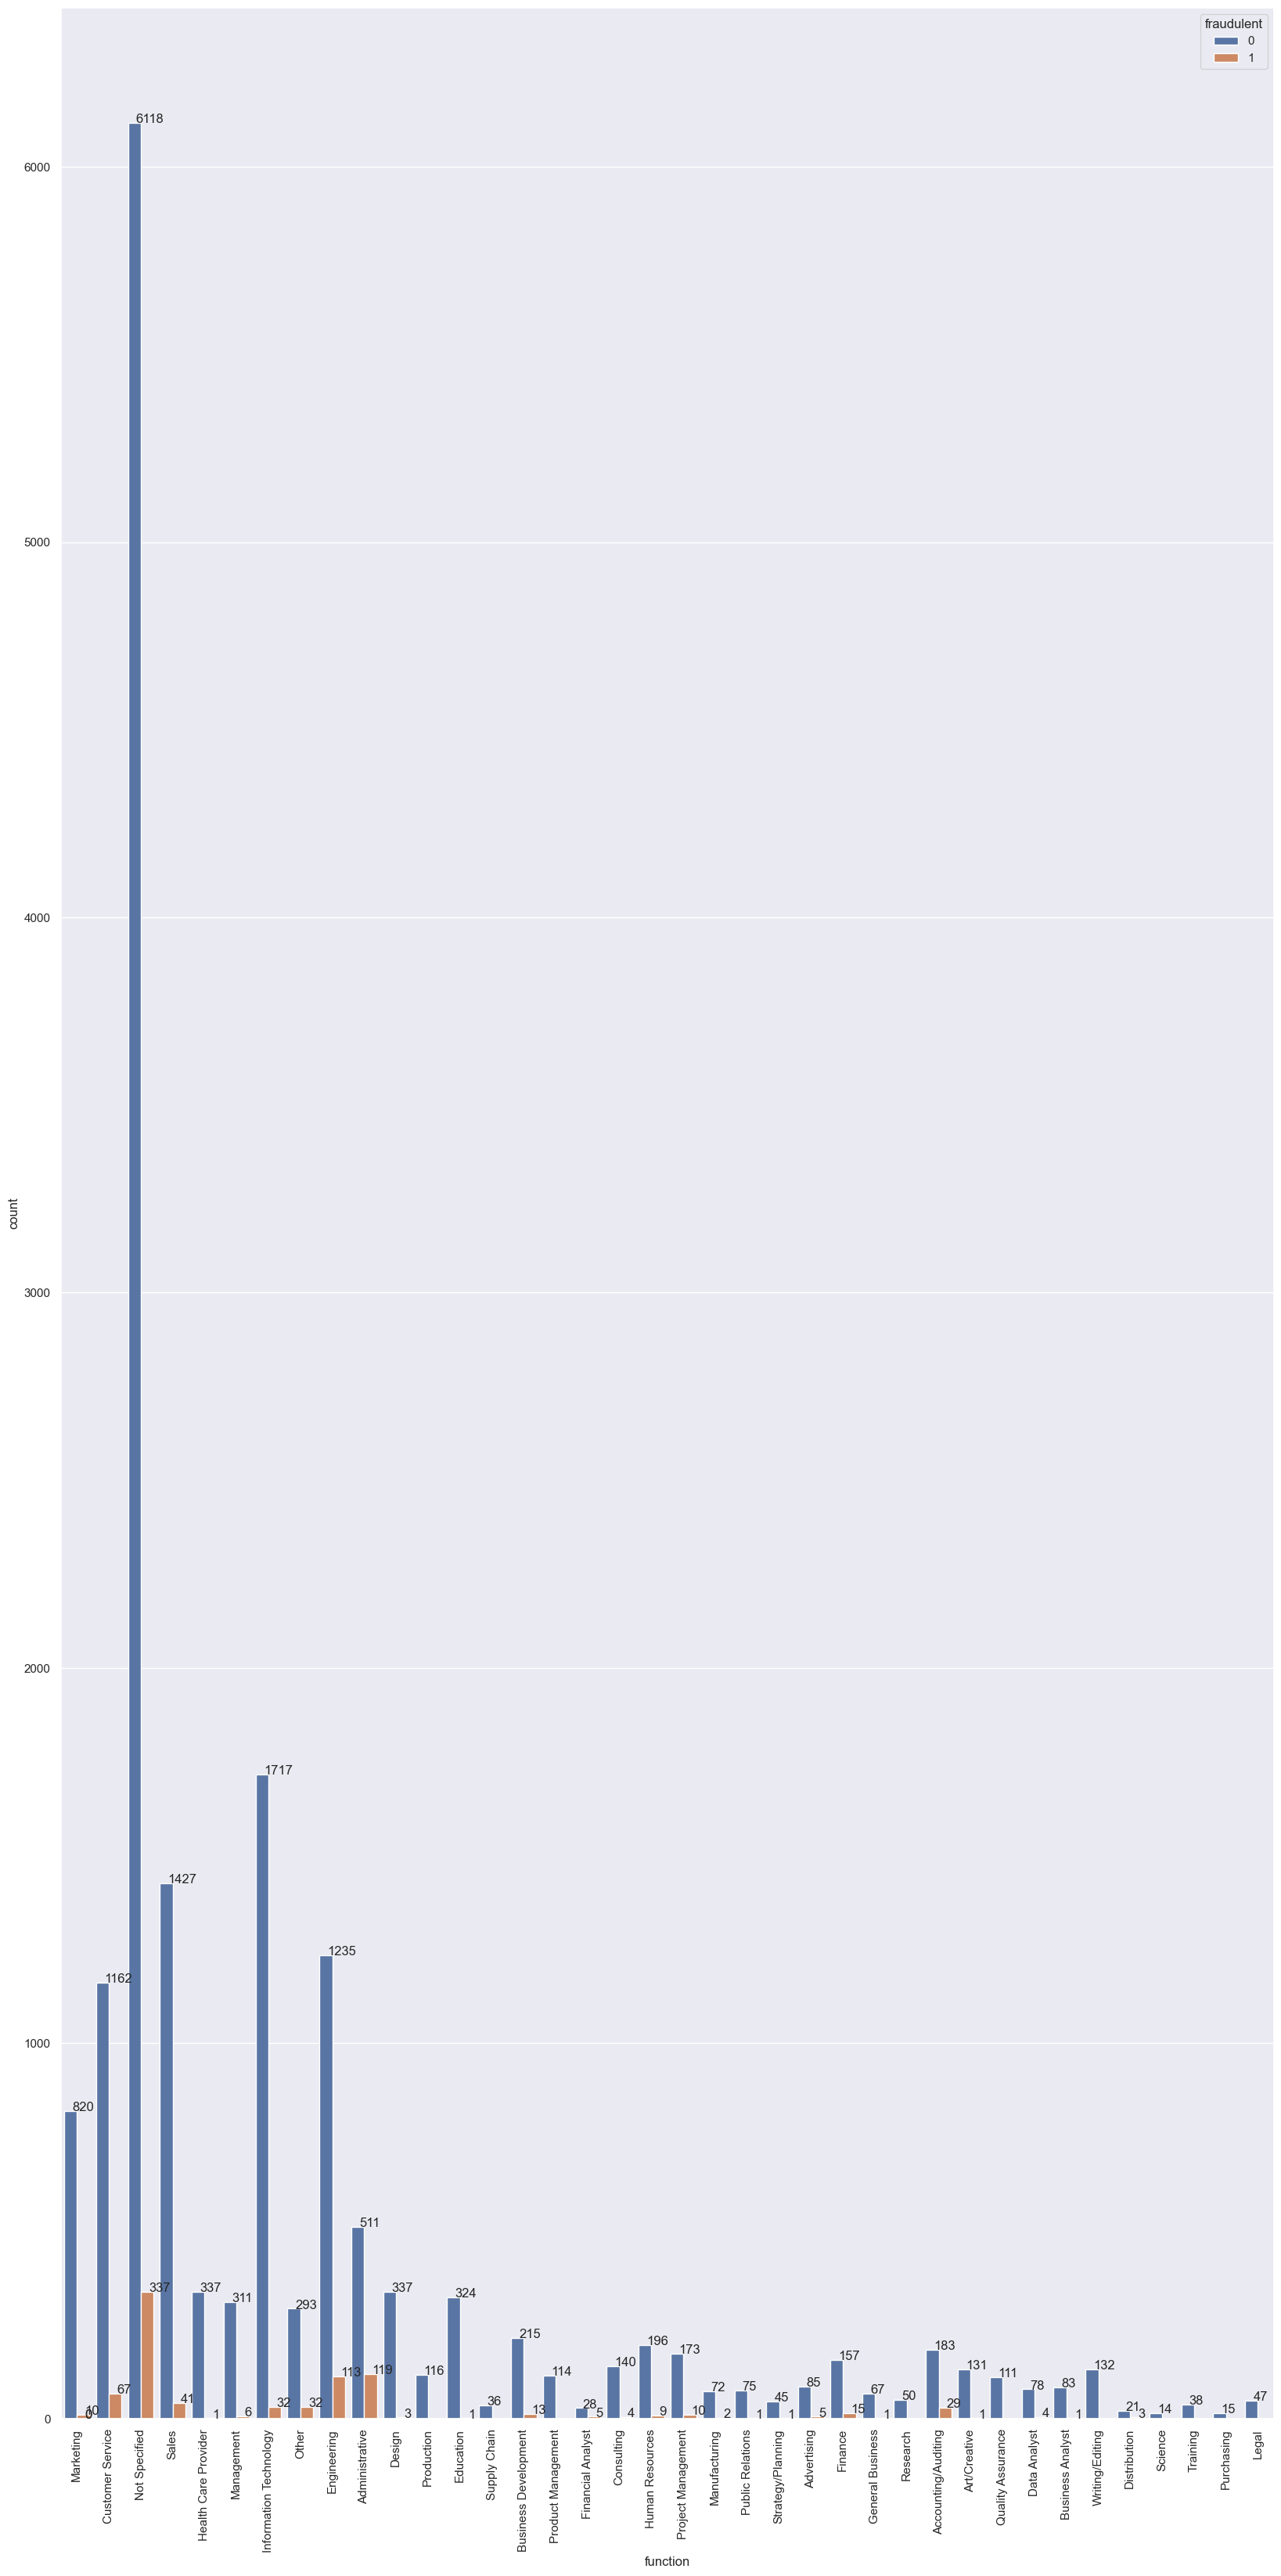

In [61]:
plots(label[6],'fraudulent')#function

# INFERENCE
From the above graphs, we can say that the number of real applicants is more than that of fake applicants given any label from the attributes plotted apart from **'Some High School Coursework'** label in **'required_education'** attribute. We can also find the labels which have a larger probability of being a real or fake application from the plots.

* **Telecommuting** - A real job offer has more chances of providing telecommuting compared to that of a fake job.
* **Company Logo** - A fake job offer has more chances of having a company logo compared to that of a real job.
* **Questions** - A real job offer has more chances of providing questions compared to that of a fake job.
* **Employement** - Even though Full-Time jobs have the most number of real job offers, a job that provides Temporary employement has the highest probability of providing real jobs compared to the rest and Part-Time employement has the least probability.
* **Experience** - Even though jobs that did not specify experience level have the most number of real job offers, a job that requires Associate level experience has the highest probability of providing real jobs compared to the rest and Part-Time employement has the least proobability.
* **Education** - Even though jobs that did not specify any required education has the most number of real job offers, A job that requires a Bachelor's degree has the highest probability of providing real jobs compared to the rest while job that requires some high school coursework has the least chances of offering a real job. Vocational Degree and Vocational Diploma don't have any fake job offers.  
* **Functions** - 'Production','Supply Chain','Product Management','Research','Quality Assurance','Writing/Editing','Science','Training','Purchasing','Legal' functions dont have any fake job offers. While 'Engineering' and 'Administrative' have more than 100 fake job offers and jobs that didn't provide any functions have the most number of fake job offers (300). Other functions have too little to no fake job offers.

**TEXT CLEANING**

In [62]:
#REMOVING STOPWORDS AND SYMBOLS FROM ATTRIBUTES WITH LENGTHY TEXTS (['company_profile','description','requirements','benefits'])
nltk.download('stopwords')
stop = stopwords.words()
sym = "!@#$%^&*+-={}[]|\"':;<>,.?/`~()_" #SYMBOLS TO BE REMOVED
listsym = ([*sym])
listsym.append("'")
listsym.append('"')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [67]:
string_labels = ['company_profile','description','requirements','benefits']
for label in string_labels:
    df1[label] =  df1[label].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    for j in range(df1.shape[0]):
        for i in listsym:
            df1.at[j,label] = df1.at[j,label].replace(i,"")

**DATA ANALYSIS - NOT SPECIFIED**

In [65]:
realcount = (df1['fraudulent']==0).sum() #Number of real applications
fakecount = (df1['fraudulent']==1).sum() #Number of fake applications


# FUNCTION TO CALCULATE THE NUMBER OF NOT SPECIFIED ENTRIES IN VARIOUS ATTRIBUTES ALONG WITH THE RATIO OF NOT SPECIFIED TO REAL AND FAKE APPLICATIONS

def not_specified(labelname,name):   
    df_real = pd.DataFrame(df1[labelname].loc[df1['fraudulent']==0])
    notspecreal = (df_real[labelname]=='Not Specified').sum()
    print(name +'\n-----------------\n\nREAL\n-----------\nNumber of Real applications that have not specified ' + name + ' = {:.0f}'.format(notspecreal))
    print('Number of Real applications = {:.0f}'.format(realcount))
    print('Ratio (Not Specified Real applications / Real applications) = {:.6f}'.format(notspecreal/realcount))
    df_fake = pd.DataFrame(df1[labelname].loc[df1['fraudulent']==1])
    notspecfake = (df_fake[labelname]=='Not Specified').sum()
    print('\n\nFAKE\n-----------\nNumber of Fake applications that have not specified ' + name + ' = {:.0f}'.format(notspecfake))
    print('Number of Fake applications = {:.0f}'.format(fakecount))
    print('Ratio (Not Specified Fake applications / Fake applications) = {:.6f}'.format(notspecfake/fakecount))

for i in df1.columns:
    not_specified(i,i.upper())
    print('\n')

TITLE
-----------------

REAL
-----------
Number of Real applications that have not specified TITLE = 0
Number of Real applications = 17014
Ratio (Not Specified Real applications / Real applications) = 0.000000


FAKE
-----------
Number of Fake applications that have not specified TITLE = 0
Number of Fake applications = 866
Ratio (Not Specified Fake applications / Fake applications) = 0.000000


LOCATION
-----------------

REAL
-----------
Number of Real applications that have not specified LOCATION = 327
Number of Real applications = 17014
Ratio (Not Specified Real applications / Real applications) = 0.019219


FAKE
-----------
Number of Fake applications that have not specified LOCATION = 19
Number of Fake applications = 866
Ratio (Not Specified Fake applications / Fake applications) = 0.021940


DEPARTMENT
-----------------

REAL
-----------
Number of Real applications that have not specified DEPARTMENT = 11016
Number of Real applications = 17014
Ratio (Not Specified Real applicatio

**DATA ANALYSIS - WORD FREQUENCY**

In [68]:
#FUNCTION TO RETURN THE 20 MOST FREQUENTLY OCCURING WORDS IN REAL/FAKE APPLCATIONS GIVEN THE ATTRIBUTE

#GIVEN WHETHER AN APPLICATION IS REAL OR FAKE, THE PROBABILITY OF THE WORD APPEARING IN THAT CATEGORY IS DIPLAYED

def frequent(lab,key):
    
    list_of_words = []
    if key == "real":
        f=0
        count = realcount
    else:
        f=1
        count = fakecount
    
    for i in (df1[lab].loc[df1['fraudulent']==f]):
        list_of_words.append((' '.join(dict.fromkeys(i.split()))))

    rand = ' '.join(list_of_words)
    listx = list(rand.split(" "))
    ratiolist = list(pd.Series(listx).value_counts()/count)
    _count = pd.DataFrame(pd.Series(listx).value_counts())
    _count. rename(columns = {_count.columns[0]:'Count'}, inplace = True)
    _count['Probability'] = ratiolist
    print("Frequently appearing words in " + lab + " of " + key + " applications")
    print(_count.head(20))
    list_of_words.clear()

In [69]:
frequent('location','real')
frequent('location','fake')

Frequently appearing words in location of real applications
           Count  Probability
US,         9868     0.579993
GB,         2353     0.138298
CA,         2351     0.138180
,           2085     0.122546
NY,         1191     0.070001
London      1105     0.064947
LND,         986     0.057952
GR,          937     0.055072
San          829     0.048725
TX,          823     0.048372
New          807     0.047432
York         766     0.045022
I,           688     0.040437
Athens       568     0.033384
Francisco    498     0.029270
IL,          477     0.028036
DE,          398     0.023393
FL,          385     0.022628
IN,          380     0.022335
OH,          354     0.020806
Frequently appearing words in location of fake applications
             Count  Probability
US,            725     0.837182
CA,            155     0.178984
TX,            152     0.175520
Houston         92     0.106236
NY,             68     0.078522
,               57     0.065820
San             57     0.0

In [70]:
frequent('department','real')
frequent('department','fake')

Frequently appearing words in department of real applications
             Count  Probability
Specified    11016     0.647467
Not          11016     0.647467
Sales          627     0.036852
Marketing      507     0.029799
Engineering    481     0.028271
Operations     328     0.019278
Development    298     0.017515
IT             263     0.015458
Product        220     0.012931
Services       182     0.010697
Technology     170     0.009992
Customer       126     0.007406
&              121     0.007112
Design         101     0.005936
Management      97     0.005701
Service         93     0.005466
and             92     0.005407
Finance         87     0.005113
Information     86     0.005055
Business        83     0.004878
Frequently appearing words in department of fake applications
                    Count  Probability
Not                   531     0.613164
Specified             531     0.613164
Engineering            56     0.064665
&                      31     0.035797
Energy   

In [71]:
frequent('salary_range','real')
frequent('salary_range','fake')

Frequently appearing words in salary_range of real applications
              Count  Probability
Not           14369     0.844540
Specified     14369     0.844540
0-0             138     0.008111
40000-50000      65     0.003820
30000-40000      51     0.002998
45000-67000      37     0.002175
25000-30000      32     0.001881
70000-90000      30     0.001763
80000-100000     30     0.001763
50000-80000      29     0.001704
55000-75000      28     0.001646
50000-70000      28     0.001646
35000-45000      27     0.001587
60000-80000      27     0.001587
40000-60000      26     0.001528
40000-45000      25     0.001469
30000-50000      24     0.001411
25000-35000      24     0.001411
30000-35000      24     0.001411
50000-60000      23     0.001352
Frequently appearing words in salary_range of fake applications
               Count  Probability
Not              643     0.742494
Specified        643     0.742494
7200-1380000      10     0.011547
30000-50000        8     0.009238
250000-50

In [72]:
frequent('company_profile','real')
frequent('company_profile','fake')

Frequently appearing words in company_profile of real applications
            Count  Probability
We           7580     0.445515
team         4493     0.264077
work         4463     0.262313
Our          4289     0.252087
company      4202     0.246973
companies    3374     0.198307
business     2986     0.175503
services     2983     0.175326
The          2854     0.167744
Not          2774     0.163042
Specified    2721     0.159927
solutions    2645     0.155460
technology   2622     0.154108
clients      2574     0.151287
amp          2520     0.148113
world        2398     0.140943
time         2330     0.136946
experience   2182     0.128247
working      2095     0.123134
great        2039     0.119842
Frequently appearing words in company_profile of fake applications
            Count  Probability
Specified     587     0.677829
Not           587     0.677829
Our           142     0.163972
technology     92     0.106236
Solutions      92     0.106236
We             89     0.10277

In [73]:
frequent('description','real')
frequent('description','fake')

Frequently appearing words in description of real applications
             Count  Probability
team          8470     0.497825
work          7257     0.426531
We            6458     0.379570
The           5503     0.323440
experience    5083     0.298754
company       4723     0.277595
business      4670     0.274480
development   4027     0.236687
customer      3947     0.231985
working       3745     0.220113
management    3450     0.202774
support       3388     0.199130
This          3322     0.195251
amp           3309     0.194487
including     3305     0.194252
role          3257     0.191431
position      3254     0.191254
product       3143     0.184730
skills        3088     0.181498
based         3045     0.178970
Frequently appearing words in description of fake applications
             Count  Probability
work           467     0.539261
We             357     0.412240
team           254     0.293303
experience     252     0.290993
company        248     0.286374
skills    

In [74]:
frequent('requirements','real')
frequent('requirements','fake')

Frequently appearing words in requirements of real applications
               Count  Probability
experience      9434     0.554485
work            5722     0.336311
skills          5617     0.330140
years           5478     0.321970
communication   4635     0.272423
knowledge       3448     0.202657
ability         3424     0.201246
degree          3368     0.197955
team            3230     0.189844
working         3217     0.189080
written         3204     0.188316
required        2939     0.172740
Not             2597     0.152639
management      2589     0.152169
Specified       2551     0.149935
related         2290     0.134595
development     2236     0.131421
understanding   2211     0.129952
customer        2207     0.129717
verbal          2174     0.127777
Frequently appearing words in requirements of fake applications
               Count  Probability
experience       366     0.422633
work             267     0.308314
skills           266     0.307159
years            214  

In [75]:
frequent('requirements','real')
frequent('requirements','fake')

Frequently appearing words in requirements of real applications
               Count  Probability
experience      9434     0.554485
work            5722     0.336311
skills          5617     0.330140
years           5478     0.321970
communication   4635     0.272423
knowledge       3448     0.202657
ability         3424     0.201246
degree          3368     0.197955
team            3230     0.189844
working         3217     0.189080
written         3204     0.188316
required        2939     0.172740
Not             2597     0.152639
management      2589     0.152169
Specified       2551     0.149935
related         2290     0.134595
development     2236     0.131421
understanding   2211     0.129952
customer        2207     0.129717
verbal          2174     0.127777
Frequently appearing words in requirements of fake applications
               Count  Probability
experience       366     0.422633
work             267     0.308314
skills           266     0.307159
years            214  

In [ ]:
frequent('industry','real')
frequent('industry','fake')

**PREPROCESSING**

In [76]:
le = preprocessing.LabelEncoder()
#ASSIGNS NUMBER TO EVERY LABEL
for i in df1.columns:
    le.fit(df1[i])
    df1[i]=le.transform(df1[i])

In [77]:
df1.head(15)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,6043,2536,758,872,1548,4010,3568,2995,0,1,0,3,4,6,88,22,0
1,2183,1073,1162,872,15,6837,10493,5323,0,1,0,1,6,6,75,7,0
2,1763,1868,831,872,1393,6999,4411,2995,0,1,0,2,6,6,88,23,0
3,299,1704,1055,872,946,9200,2946,3132,0,1,0,1,5,1,22,32,0
4,975,1742,831,872,1182,5229,6488,2061,0,1,1,1,5,1,51,16,0
5,375,2085,831,872,896,5388,5786,2995,0,0,0,2,6,6,88,23,0
6,4296,216,50,296,522,14260,11203,5667,0,1,1,1,5,5,90,20,0
7,5550,1565,831,872,90,13869,3456,1332,0,1,1,2,6,6,88,23,0
8,4201,1773,831,872,1169,4944,4987,2995,0,1,1,1,0,6,58,23,0
9,2210,1384,831,872,899,9630,5393,2995,0,1,0,4,2,4,39,7,0


# **MODEL**

In [78]:
X=df1.drop(['fraudulent'],axis=1)
Y=df1["fraudulent"]
X_train,X_test,Y_train,Y_test = (train_test_split(X, Y, test_size=0.25, shuffle=True))

In [79]:
#FUNCTION TO TRAIN THE MODEL, PREDICT THE LABELS FOR TEST SAMPLES AND CALCULATE THE ACCURACY AND PRECISION

def traintest(model,modelname):
    
    start = time.time()
    print("\n------------------\nMODEL - "+ modelname + "\n-----------------\n")

    #Training the model
    model.fit(X_train, Y_train) 

    #Predicting 
    Y_pred = model.predict(X_test)

    #Calculating the accuracy
    accuracy = metrics.accuracy_score(Y_test, Y_pred)
    print("Accuracy = " + '{:.2f}%'.format(accuracy*100))

    #Calculating the precision
    precision = metrics.precision_score(Y_test, Y_pred)
    print("Precision = " + '{:.2f}%'.format(precision*100))

    #Total Time
    end = time.time() - start
    print("Time = " + '{:.2f}s'.format(end))

In [80]:
#ACCURACY ALONG WITH THE TIME IS NOTED FOR THIS PURPOSE

import warnings
warnings.filterwarnings('ignore')  

traintest(GaussianNB(),"NAIVE BAYES")
traintest(DecisionTreeClassifier(),"DECISION TREE")
traintest(RandomForestClassifier(),"RANDOM FOREST")
traintest(KNeighborsClassifier(),"KNN")
traintest(SVC(),"SVM")
traintest(LogisticRegression(solver='liblinear'),"LOGISITC REGRESSION")


------------------
MODEL - NAIVE BAYES
-----------------

Accuracy = 93.65%
Precision = 30.98%
Time = 0.01s

------------------
MODEL - DECISION TREE
-----------------

Accuracy = 96.69%
Precision = 65.28%
Time = 0.10s

------------------
MODEL - RANDOM FOREST
-----------------

Accuracy = 98.10%
Precision = 93.88%
Time = 2.83s

------------------
MODEL - KNN
-----------------

Accuracy = 95.62%
Precision = 57.89%
Time = 1.24s

------------------
MODEL - SVM
-----------------

Accuracy = 95.21%
Precision = 0.00%
Time = 3.73s

------------------
MODEL - LOGISITC REGRESSION
-----------------

Accuracy = 95.53%
Precision = 88.89%
Time = 0.27s


# **NOTES**

I would consider a ML algorithm rather than a Deep Learning Model to classify the job application because there are 15 attributes to be considered apart from raw text from 'company_profile','description','requirements' and 'benefits', some of them being binary labels. Also a Deep Learning model requires a lot of training data and given the number of training samples, the model may tend to overfit and would take longer time to train.

Among the ML algorithms, Random Forest Classifier is preferred for this purpose. Even though it takes a bit longer to train and predict the labels than Naive Bayes, Logistic Regression, KNN and Decision Tree, it provides slightly better accuracy and even better precision compared to other algorithms. 

**ACCURACY = 98.17%**

**PRECISION = 96.60%**